# Benchmark for Clustering

In [1]:
"""Load/import helper functions"""

import time
import random
from LocalPopular import locally_popular_clustering, extract_labels_from_communities, time_tester, calculate_scores_clustering, \
    locally_popular_clustering_with_euclid_graphs

from GraphFunctions import generate_agents, calculate_euclidian_relationships, create_graph, \
    my_make_circles, create_graphs_euclid, create_graphs_kNN, \
    generate_graph,create_graphs_hop_distance, create_graphs_hop_distance_abs,randomize_graph_pos_labels

from PlotHelperFunctions import plot_clustering, plot_stuff

from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_moons, load_breast_cancer, load_iris
from sklearn.metrics import rand_score
import numpy as np
import networkx as nx
from scipy.spatial import distance

from community_detection.leiden import leiden
from community_detection.louvain import louvain
from community_detection.quality_functions import CPM, Modularity



## Create Graphs

In [2]:
repetitions = 1    #Number of random isomorph permutation for each graph


moon_agents,moon_truth = make_moons(n_samples=300, noise=0.05)
moon_perm_agents = []
moon_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(moon_agents,moon_truth)
    moon_perm_agents += [g]
    moon_perm_truth += [t]



circle_agents, circle_truth = my_make_circles(300)

circle_perm_agents = []
circle_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(circle_agents,circle_truth)
    circle_perm_agents += [g]
    circle_perm_truth += [t]

cancer = load_breast_cancer()

cancer_agents = cancer['data']
cancer_truth = cancer['target']

cancer_perm_agents = []
cancer_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(cancer_agents,cancer_truth)
    cancer_perm_agents += [g]
    cancer_perm_truth += [t]

iris = load_iris()
iris_agents = iris['data']
iris_truth = iris['target']


iris_perm_agents = []
iris_perm_truth = []
for i in range(repetitions):
    g,t = randomize_graph_pos_labels(iris_agents,iris_truth)
    iris_perm_agents += [g]
    iris_perm_truth += [t]


## Run the algorithms


## Gather the numbers

We can use the collected_data dictionairy to build a table for better comparison


In [3]:
import itertools
import timeit
import pandas as pd
import numbers

dfs = []
labels = [(0.2,0.2), (0.25,0.35),(0.4,0.4)]

for treshold in labels:
    collected_data = {}
    for repetitions in range(10):
        f = treshold[0]   #f-bound
        e = treshold[1]   
        data = [ moon_perm_agents,circle_perm_agents,cancer_perm_agents,iris_perm_agents]
        expected_clusters = [2,3,2,3]
        graph_names = ['Moons','My 3 Circles', 'Cancer', 'Iris']
        graph_truths =  [moon_perm_truth,circle_perm_truth,cancer_perm_truth,iris_perm_truth]
        
        
        kmeans = lambda agents, clusters: KMeans(n_clusters = clusters).fit_predict(agents)
        dbscan = lambda agents, clusters: DBSCAN(eps=0.2, min_samples=5).fit_predict(agents)
        
        kmeans_out = None
        dbscan_out = None
        
        lp_a_b =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='B',pre=pre)
        lp_a_f =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='F',pre=pre)
        lp_a_e =lambda agents, initial_clustering, pre: locally_popular_clustering_with_euclid_graphs(agents, f, e, initial_clustering,mode='E',pre=pre)
        
        algorithms = [ kmeans, dbscan,lp_a_b,lp_a_f,lp_a_e]
        algo_names = [ 'kmeans', 'dbscan','LP (Balanced) Heuristic',\
                       'LP (Friend-Oriented) Heuristic','LP (Enemy-Averse) Heuristic']
        is_lp_heuristic = [False,False,True, True, True]
    
    
        for ((graph, g_name,clusters,truth), (algo, a_name,lp_heuristic)) in \
            itertools.product(zip(data, graph_names, expected_clusters,graph_truths), zip(algorithms, algo_names,is_lp_heuristic)):
        
                
            agents = graph
        
            if lp_heuristic:
                # start with everyone alone
                a_name_modified = a_name + ' starting with everyone alone'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,len(agents[0]),None).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with random clustering 
        
                a_name_modified = a_name + ' starting with predicted number of clusters'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,clusters,None).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
        
                # start with the output of k-means
                a_name_modified = a_name + ' starting with the output of k-means'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,clusters,kmeans).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
        
                rand_score_with_init = sum(rand_score(out, k) for out, k in zip(outputs, kmeans_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                # start with the output of dbscan
                a_name_modified = a_name + ' starting with the output of dbscan'
                print(f"Running {a_name_modified} on {g_name} … ", end='')
                test_callable = lambda a: list(algo(a,clusters,kmeans).values())
                times,outputs = time_tester(test_callable,graph)
                avg_time = sum(times)/len(times)
        
                rand_score_with_init = sum(rand_score(out, db) for out, db in zip(outputs, dbscan_out)) / len(outputs)
                scores['Rand Score with initial clustering'] = rand_score_with_init
                
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
        
                if (a_name_modified, g_name) not in collected_data:
                    collected_data[(a_name_modified, g_name)] = []
                collected_data[(a_name_modified, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
        
                    
            else:
        
                print(f"Running {a_name} on {g_name} … ", end='')
                test_callable = lambda a : algo(a, clusters)
                    
                times,outputs = time_tester(test_callable,graph)
                if(algo == kmeans):
                    kmeans_out = outputs
                if(algo == dbscan):
                    dbscan_out = outputs
                avg_time = sum(times)/len(times)
                scores = calculate_scores_clustering(outputs,truth,agents)
                scores['Time'] = avg_time
                
                if (a_name, g_name) not in collected_data:
                    collected_data[(a_name, g_name)] = []
                collected_data[(a_name, g_name)].append(scores)
                print(f"execution time: ~ {avg_time:.6f} seconds.")
                for score_name in scores.keys():
                    print(score_name,": ~",scores.get(score_name))
    
       
    records = []

    for (method, dataset), metrics_list in collected_data.items():
        record = {'Method': method, 'Dataset': dataset}
        keys = metrics_list[0].keys()
        for key in keys:
            # check if this metric is numeric
            if isinstance(metrics_list[0][key], numbers.Number):
                values = [m[key] for m in metrics_list]
                mean = sum(values) / len(values)
                std = (sum((v - mean) ** 2 for v in values) / len(values)) ** 0.5
                record[key] = (mean, std)
            else:
                # if not numeric (e.g., a string), just copy one of them
                record[key] = metrics_list[0][key]
        records.append(record)
    
    df = pd.DataFrame(records)
    
    dfs.append(df)

dfs[0].head()

Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.367105 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.36710499998298474
Running dbscan on Moons … execution time: ~ 0.008796 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.008795700006885454
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.930090 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 9.930090400011977
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.745524 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.7455244999728166
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.685995 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.6859946000040509
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.673557 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.673556900001131
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 10.118025 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 10.118025200004922
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.810352 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.8103515999973752
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.933065 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.9330646000162233
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.954713 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.9547132999869063
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 13.175174 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 13.175173700001324
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 1.121916 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 1.1219162000052165
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.906981 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9542697881828317
Time : ~ 0.9069813000096474
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.946363 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.9463625999924261
Running kmeans on My 3 Circles … execution time: ~ 0.008249 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.008249000005889684
Running dbscan on My 3 Circles … execution time: ~ 0.005940 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005940400005783886
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 10.447241 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 10.447240600013174
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.625905 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6259050999942701
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584828 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5848276000178885
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.648767 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6487665000022389
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.687776 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 8.687775599973975
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.639063 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6390633000119124
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.618604 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.693422519509476
Time : ~ 0.6186038000159897
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584641 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.5846409999940079
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.160593 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 8.160593100008555
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.764939 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7649391999875661
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583832 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5838319000031333
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.615114 seconds.
Rand Index : ~ 0.7519955406911929
Silhouette Score : ~ 0.3821139438552644
Davies Bouldin Score : ~ 0.9859173035927314
Time : ~ 0.6151136999833398
Running kmeans on Cancer … execution time: ~ 0.008811 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008810700004687533
Running dbscan on Cancer … execution time: ~ 0.011833 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.011832700023660436
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.856436 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 55.85643620000337
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.043292 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0432924999913666
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.884745 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.884745399991516
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.052381 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0523811999883037
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.454542 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 61.45454159998917
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.196105 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.1961049000092316
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.062804 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.0628042000171263
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.916348 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9163481000286993
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.268056 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 55.2680560000008
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.243743 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.2437434000021312
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.970849 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9708491000055801
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.948249 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9482491000089794
Running kmeans on Iris … execution time: ~ 0.004856 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.004855500010307878
Running dbscan on Iris … execution time: ~ 0.002564 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0025636999926064163
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.183327 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1833274999808054
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209859 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.20985869999276474
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.185676 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18567589999292977
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.174116 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17411550000542775
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.052882 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0528817000158597
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209621 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.2096214999910444
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.184471 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1844711999874562
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.185745 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.18574459999217652
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.134137 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1341369000147097
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206189 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.567165303685323
Time : ~ 0.2061890000186395
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171027 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17102710000472143
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.169305 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1693045000138227
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005655 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.00565529998857528
Running dbscan on Moons … execution time: ~ 0.004196 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004196199995931238
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.992028 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 8.992027800006326
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.576827 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5768272999848705
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.554476 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.5544760999910068
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578720 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5787202999927104
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.962825 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.962825299997348
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.603645 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6036454999994021
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571553 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.5715526999847498
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.575651 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5756505999888759
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.962939 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.962939499993809
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.596353 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5963532000023406
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576700 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9542697881828317
Time : ~ 0.5767001999774948
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.604111 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.6041114999970887
Running kmeans on My 3 Circles … execution time: ~ 0.008045 seconds.
Rand Index : ~ 0.7450836120401337
Silhouette Score : ~ 0.4186495575613176
Davies Bouldin Score : ~ 0.8838086513810103
Time : ~ 0.00804519999655895
Running dbscan on My 3 Circles … execution time: ~ 0.004253 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004252899991115555
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.518770 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 9.518770399998175
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.840637 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.8406372999888845
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.632712 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Rand Score with initial clustering : ~ 0.7038795986622074
Time : ~ 0.6327122999937274
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.625810 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6258097999962047
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.667420 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 9.667420200014021
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.717424 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.7174235999991652
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.625258 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Rand Score with initial clustering : ~ 0.7038795986622074
Time : ~ 0.6252583999885246
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.638156 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Time : ~ 0.638155699998606
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.528335 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 9.528334799979348
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.626439 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6264386999828275
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.643661 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Rand Score with initial clustering : ~ 0.7756298773690078
Time : ~ 0.6436613000114448
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.644823 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6448231999820564
Running kmeans on Cancer … execution time: ~ 0.008350 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.00835030002053827
Running dbscan on Cancer … execution time: ~ 0.006739 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006738800002494827
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.333448 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 59.3334483000217
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.234170 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.234169800009113
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.051184 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.051184399984777
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.099068 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0990675000066403
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 63.449222 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 63.44922249999945
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.242621 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.2426214999868535
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.080452 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.080452399997739
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.090980 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0909796000050846
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.796175 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 59.796174999995856
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.205063 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.205062799999723
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.158238 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.158238400006667
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.060026 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0600258999911603
Running kmeans on Iris … execution time: ~ 0.007099 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628473
Time : ~ 0.007098699978087097
Running dbscan on Iris … execution time: ~ 0.002599 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002598899998702109
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.192235 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1922348999942187
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190745 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.1907447000266984
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.178340 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.17833960001007654
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166900 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1668995000072755
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.139565 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1395653999934439
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195693 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.180741 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1807412999914959
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178481 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17848140001296997
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.099837 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0998374999908265
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201569 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.56716530368

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.178321 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1783210000139661
Running kmeans on Moons … execution time: ~ 0.005040 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005039600015152246
Running dbscan on Moons … execution time: ~ 0.003740 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0037397000123746693
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.567020 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 9.567019500012975
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.607246 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6072462000011001
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599262 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5992616000003181
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.592218 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5922180000052322
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.799552 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 9.799551900010556
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.601283 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6012830999970902
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.577818 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.577817600016715
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.631340 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.6313395999895874
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.750844 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 9.750844499998493
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.641771 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6417706000211183
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.595196 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9606688963210702
Time : ~ 0.5951963000115938
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598825 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5988248999929056
Running kmeans on My 3 Circles … execution time: ~ 0.007358 seconds.
Rand Index : ~ 0.7468004459308807
Silhouette Score : ~ 0.41741999997875423
Davies Bouldin Score : ~ 0.8882191560159853
Time : ~ 0.007357800001045689
Running dbscan on My 3 Circles … execution time: ~ 0.005034 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005034000001614913
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.276094 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 9.27609400000074
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.669580 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6695795000123326
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.671566 seconds.
Rand Index : ~ 0.7422742474916388
Silhouette Score : ~ 0.3700668715658873
Davies Bouldin Score : ~ 1.0631263570789207
Rand Score with initial clustering : ~ 0.7003121516164994
Time : ~ 0.6715658000030089
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.613707 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6137073999852873
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.845656 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 9.845655599987367
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.792045 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.7920449999801349
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.679871 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.7754960981047938
Time : ~ 0.67987130000256
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.614426 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Time : ~ 0.6144262999878265
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.504612 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 9.504611799988197
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.716647 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7166468000214081
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.608699 seconds.
Rand Index : ~ 0.7519955406911929
Silhouette Score : ~ 0.3821139438552644
Davies Bouldin Score : ~ 0.9859173035927314
Rand Score with initial clustering : ~ 0.7050836120401338
Time : ~ 0.6086985000001732
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.650758 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6507577000011224
Running kmeans on Cancer … execution time: ~ 0.009773 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.009773199999472126
Running dbscan on Cancer … execution time: ~ 0.007323 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.007323099998757243
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.666518 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 58.66651819998515
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.923403 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9234033999964595
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.823233 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.82323290000204
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.003692 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.003692400001455
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.028903 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 60.02890259999549
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.864325 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.8643254999769852
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.902338 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9023383000167087
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.016144 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.016143800021382
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.712506 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 53.71250599998166
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.965453 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9654527000093367
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.860316 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.8603159000049345
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.885674 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.8856740000192076
Running kmeans on Iris … execution time: ~ 0.006161 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.006160699995234609
Running dbscan on Iris … execution time: ~ 0.002461 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002461099997162819
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.015895 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.015895399992587
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.202779 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.20277859998168424
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173182 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.17318159999558702
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164398 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16439799999352545
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.071632 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0716320999781601
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190625 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.161030 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1610297999868635
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.183830 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1838304000266362
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.200509 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.2005094999913126
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205038 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.567165303685

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.156694 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15669440000783652
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175431 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17543070000829175
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005082 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005081999988760799
Running dbscan on Moons … execution time: ~ 0.004604 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004604299989296123
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.071374 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 8.071373899991158
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.565975 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.565975100005744
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.542186 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5421862999792211
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.527608 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5276080999756232
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.754566 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.754566199990222
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.578583 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5785831000248436
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582292 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5822916000033729
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571592 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5715923999960069
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.171080 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.17107969999779
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.652298 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6522982000024058
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.596826 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9606688963210702
Time : ~ 0.5968258999928366
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599209 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5992093000095338
Running kmeans on My 3 Circles … execution time: ~ 0.007266 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.00726579999900423
Running dbscan on My 3 Circles … execution time: ~ 0.004164 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0041637000103946775
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.894166 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 7.89416599998367
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.634241 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6342410999932326
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.537458 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5374575000023469
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.562883 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Time : ~ 0.5628830000059679
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.131422 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 8.131422400008887
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.730407 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.7304070999962278
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573070 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.693422519509476
Time : ~ 0.573069799982477
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.564510 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.564509799994994
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.327889 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 7.32788879997679
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.633071 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6330707999877632
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573321 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5733208000019658
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.643860 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6438595999788959
Running kmeans on Cancer … execution time: ~ 0.006427 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006426800013286993
Running dbscan on Cancer … execution time: ~ 0.005847 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005846700019901618
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.230748 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 54.230747500027064
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.262011 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.2620113999873865
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.118499 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.1184988000022713
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.792614 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.7926139999763109
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.711057 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 56.71105749998242
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.936717 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9367174000071827
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.796092 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.796092199976556
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.820675 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.8206751999969129
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.923581 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 56.92358139998396
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.092397 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.092396699998062
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.125161 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.125160700001288
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.084294 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.08429420000175
Running kmeans on Iris … execution time: ~ 0.005959 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628473
Time : ~ 0.0059588000003714114
Running dbscan on Iris … execution time: ~ 0.002488 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024877999967429787
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.277570 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.2775699000048917
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209865 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.20986529998481274
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.157487 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15748719999101013
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.161942 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1619424000091385
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.160443 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1604431000014301
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.161764 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182320 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.18232049999642186
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.169660 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1696603000164032
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.018442 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.018441599997459
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.191497 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.567165303685

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.161885 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16188549998332746
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.155109 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.15510910001466982
Running kmeans on Moons … execution time: ~ 0.004487 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.0044867999968118966
Running dbscan on Moons … execution time: ~ 0.003541 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0035411000135354698
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.556511 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 8.55651090000174
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.572322 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5723218999919482
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566860 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.5668601999932434
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.547485 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5474853999912739
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.901852 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.901851900009206
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.732337 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.7323366000200622
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570769 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.570768900011899
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.606743 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.6067430999828503
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.598882 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.598881700017955
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.638775 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6387746999971569
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.569231 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9542697881828317
Time : ~ 0.5692312000028323
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.559930 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5599295000138227
Running kmeans on My 3 Circles … execution time: ~ 0.007315 seconds.
Rand Index : ~ 0.7857971014492754
Silhouette Score : ~ 0.35538059358912827
Davies Bouldin Score : ~ 0.982997060876173
Time : ~ 0.0073151999968104064
Running dbscan on My 3 Circles … execution time: ~ 0.004092 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004091600014362484
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.766942 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 8.766941899986705
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.629992 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6299921000027098
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571196 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Rand Score with initial clustering : ~ 0.6862653288740245
Time : ~ 0.5711964000074659
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566244 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Time : ~ 0.5662440999876708
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.801107 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 8.801106900005834
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.693225 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6932247999939136
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.581179 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.6866889632107024
Time : ~ 0.5811785999976564
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.653347 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6533470999856945
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.502307 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 8.50230749999173
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.740051 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7400505999976303
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.569590 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6851727982162765
Time : ~ 0.569590099999914
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.572790 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.5727899999765214
Running kmeans on Cancer … execution time: ~ 0.006738 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0067377999948803335
Running dbscan on Cancer … execution time: ~ 0.005242 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00524189998395741
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.047586 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 53.04758559999755
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.102403 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.1024032999994233
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.053626 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.053626200009603
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.798026 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.798026000004029
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.613594 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 58.61359419999644
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.998719 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9987187999940943
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.797284 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7972844000032637
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.766967 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.7669668000016827
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 52.708724 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 52.70872419999796
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.983703 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9837025000015274
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.966255 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.966254700004356
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.983438 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9834376999933738
Running kmeans on Iris … execution time: ~ 0.004658 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.004658399993786588
Running dbscan on Iris … execution time: ~ 0.002506 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0025055000151041895
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.117117 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1171170999878086
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200541 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.2005405000236351
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.157799 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.15779889997793362
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171868 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1718682000064291
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.181502 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1815021999937017
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.186940 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185464 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18546430001151748
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.201050 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.20104970000102185
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.040738 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0407375000067987
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.207278 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.567165303685323
Time : ~ 0.20727779998560436
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179181 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17918110001483
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175832 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.1758321999805048
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005505 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005504500004462898
Running dbscan on Moons … execution time: ~ 0.004426 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004426200001034886
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.986895 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 8.986895400012145
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.647590 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6475903000100516
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.609196 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.6091961000056472
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555720 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5557202000054531
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 7.872575 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 7.872574899985921
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.577914 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5779136999917682
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.596992 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5969919000053778
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538941 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5389407000038773
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.317568 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.317567999998573
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.602883 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6028826999827288
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.563581 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9606688963210702
Time : ~ 0.5635807999933604
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.543149 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5431486000015866
Running kmeans on My 3 Circles … execution time: ~ 0.011165 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.011164700001245365
Running dbscan on My 3 Circles … execution time: ~ 0.005112 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005112100014230236
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.173429 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 8.173428600013722
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.740716 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7407155999972019
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.601059 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Rand Score with initial clustering : ~ 0.9187736900780379
Time : ~ 0.601058500004001
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.595054 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.595054400007939
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.985437 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 8.985437200026354
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.690014 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6900138999917544
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.624005 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Rand Score with initial clustering : ~ 0.693355629877369
Time : ~ 0.6240047000173945
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.612961 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Time : ~ 0.612961400009226
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.853636 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 8.853635500010569
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.656403 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6564032000023872
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598322 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5983215000014752
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.594388 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.5943878999969456
Running kmeans on Cancer … execution time: ~ 0.007284 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007284299994353205
Running dbscan on Cancer … execution time: ~ 0.005674 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005674199986970052
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.386029 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 56.386028800014174
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.206131 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.206130700011272
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.115310 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.115309699991485
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.891077 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.891077200009022
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.549595 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 60.54959489998873
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.205758 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.2057579000247642
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.936150 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.93615000002319
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.996398 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9963975999853574
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.747924 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 57.74792379999417
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.148775 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.148775300011039
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.793899 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.793899100011913
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.788990 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.7889895999978762
Running kmeans on Iris … execution time: ~ 0.005518 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.0055182999931275845
Running dbscan on Iris … execution time: ~ 0.002467 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024668000114616007
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.003338 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0033376999781467
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.193890 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.19389009999576956
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167301 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16730070000630803
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.157908 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.15790849999757484
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.064497 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0644968000124209
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203376 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.160197 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16019669998786412
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171952 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17195180000271648
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.993515 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 0.9935150999808684
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.202573 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.5671653036

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.162053 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1620530000072904
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.160388 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16038849999313243
Running kmeans on Moons … execution time: ~ 0.004189 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.004189100000075996
Running dbscan on Moons … execution time: ~ 0.003466 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0034659999946597964
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.322352 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 8.322352199989837
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.566322 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5663215999957174
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.569502 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.5695023000007495
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529702 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.529702100000577
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.540496 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.540496400004486
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.684141 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6841411000059452
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565298 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9416053511705685
Time : ~ 0.5652979000005871
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.580890 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5808903999859467
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.526530 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.526529999973718
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.586585 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5865850999834947
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550720 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9542697881828317
Time : ~ 0.5507198999985121
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.595961 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5959606999822427
Running kmeans on My 3 Circles … execution time: ~ 0.006269 seconds.
Rand Index : ~ 0.7636789297658862
Silhouette Score : ~ 0.37138002127150266
Davies Bouldin Score : ~ 0.992848141947611
Time : ~ 0.006269000004976988
Running dbscan on My 3 Circles … execution time: ~ 0.004357 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004356599994935095
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.580157 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 8.580157099990174
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.640390 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6403896999836434
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584429 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Rand Score with initial clustering : ~ 0.9099442586399108
Time : ~ 0.5844290999812074
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.609375 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6093752000015229
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.747867 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 8.747867100028088
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.648325 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6483253999904264
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.616971 seconds.
Rand Index : ~ 0.667469342251951
Silhouette Score : ~ 0.23366222904697403
Davies Bouldin Score : ~ 3.7978519287705694
Rand Score with initial clustering : ~ 0.7064659977703456
Time : ~ 0.6169709000096191
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598124 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Time : ~ 0.5981243999849539
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.540227 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 8.540226599987363
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.758367 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7583666999998968
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589367 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6973467112597548
Time : ~ 0.5893669999786653
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558659 seconds.
Rand Index : ~ 0.7519955406911929
Silhouette Score : ~ 0.3821139438552644
Davies Bouldin Score : ~ 0.9859173035927314
Time : ~ 0.5586590000020806
Running kmeans on Cancer … execution time: ~ 0.006613 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006613400008063763
Running dbscan on Cancer … execution time: ~ 0.005624 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005624000012176111
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.105892 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 56.105892399995355
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.071397 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.07139699999243
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.984190 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9841895000135992
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.018666 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.018666000018129
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.615689 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 59.61568899999838
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.991196 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9911961999896448
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.828527 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.8285266000020783
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.844166 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.844166299997596
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.931773 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 56.93177260001539
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.175684 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.17568400001619
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.082232 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.082231900014449
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.101917 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.10191689999192
Running kmeans on Iris … execution time: ~ 0.009331 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.009331400011433288
Running dbscan on Iris … execution time: ~ 0.002774 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002773699990939349
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.270982 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.2709821999887936
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.180157 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.1801573999982793
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185835 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18583520001266152
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.192454 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.19245410000439733
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.162493 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1624933000130113
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199977 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.19997730001341552
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.187147 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18714699998963624
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.186437 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.18643679999513552
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.146915 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1469149000186007
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195700 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.567165303685323
Time : ~ 0.19569990001036786
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173964 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.17396350001217797
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.158193 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.15819260000716895
Running kmeans on Moons … execution time: ~ 0.003846 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.003845899977022782
Running dbscan on Moons … execution time: ~ 0.003320 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0033198000164702535
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.324096 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 9.324096299998928
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.714555 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.7145551000139676
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548120 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5481198999914341
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566133 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5661326999834273
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.945159 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.945159299997613
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.583296 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5832961999985855
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534070 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5340701999957673
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.541186 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5411861999891698
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.474377 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 7.47437660000287
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.557579 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5575794999895152
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.590441 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9606688963210702
Time : ~ 0.5904410000075586
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566638 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5666376999870408
Running kmeans on My 3 Circles … execution time: ~ 0.008016 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.008016200008569285
Running dbscan on My 3 Circles … execution time: ~ 0.004115 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004115400020964444
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.241599 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 8.241598800028441
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.751225 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7512251999869477
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598921 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Rand Score with initial clustering : ~ 0.9187736900780379
Time : ~ 0.5989210999978241
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.595181 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Time : ~ 0.5951808999816421
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.336694 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 9.33669430000009
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.688146 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6881455999973696
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.648623 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.693422519509476
Time : ~ 0.6486229999864008
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.657209 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6572086999949533
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.395356 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 9.395356499997433
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.722369 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7223685999924783
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.732715 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.7327145999879576
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.590453 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.5904534000146668
Running kmeans on Cancer … execution time: ~ 0.007408 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007408400007989258
Running dbscan on Cancer … execution time: ~ 0.005819 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005819299985887483
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.715137 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 59.71513679999043
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.212828 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.2128276999865193
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.068213 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.0682128999906126
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.000963 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0009630999993533
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.993514 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 64.99351420000312
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.323462 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.3234617999987677
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.095318 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.095317800005432
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.112444 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.11244440000155
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.391749 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 59.3917489000014
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.987182 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9871823000139557
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.970608 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9706084000063129
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.906822 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9068219999899156
Running kmeans on Iris … execution time: ~ 0.004933 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.0049328999884892255
Running dbscan on Iris … execution time: ~ 0.002310 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0023095000069588423
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.397880 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.3978799000033177
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.204897 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.20489689998794347
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.185618 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.18561750001390465
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.172471 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17247089999727905
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.194378 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.194378099986352
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.189729 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.18972890000441112
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.161240 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9824608501118568
Time : ~ 0.1612398999859579
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166218 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16621799999848008
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.035548 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.035548000014387
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.210044 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.567165303685

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.160136 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16013599999132566
Running kmeans on Moons … execution time: ~ 0.005008 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005008200008887798
Running dbscan on Moons … execution time: ~ 0.003447 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.003447399998549372
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.929261 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 8.929260999982944
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.535247 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.535246699990239
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.579374 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5793741999950726
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550737 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5507373999862466
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.608713 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 9.608712999994168
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.684295 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6842953999876045
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565105 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5651047000137623
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603138 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.6031379999767523
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.528501 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 9.528500599990366
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.678031 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6780310999893118
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.660406 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9606688963210702
Time : ~ 0.6604064000130165
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.618909 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.6189087000093423
Running kmeans on My 3 Circles … execution time: ~ 0.006735 seconds.
Rand Index : ~ 0.7450836120401337
Silhouette Score : ~ 0.4186495575613176
Davies Bouldin Score : ~ 0.8838086513810103
Time : ~ 0.0067347000003792346
Running dbscan on My 3 Circles … execution time: ~ 0.004557 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004556900006718934
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 9.510634 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 9.510633999976562
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.703721 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.703721099998802
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.615361 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Rand Score with initial clustering : ~ 0.7038795986622074
Time : ~ 0.6153614000068046
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.626927 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6269270000047982
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.819722 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 9.819722399988677
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.852334 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.8523336999933235
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.614075 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.7777926421404683
Time : ~ 0.6140753000217956
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.620083 seconds.
Rand Index : ~ 0.750546265328874
Silhouette Score : ~ 0.3827563092986026
Davies Bouldin Score : ~ 0.9869866989778303
Time : ~ 0.6200826999847777
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.843842 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 9.843842100002803
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.689673 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6896732999884989
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.644487 seconds.
Rand Index : ~ 0.7497435897435898
Silhouette Score : ~ 0.37370020172496893
Davies Bouldin Score : ~ 1.0292930083572107
Rand Score with initial clustering : ~ 0.7029431438127091
Time : ~ 0.6444873999862466
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.669698 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6696984999871347
Running kmeans on Cancer … execution time: ~ 0.010131 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.010131399991223589
Running dbscan on Cancer … execution time: ~ 0.005955 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005954899999778718
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 59.470796 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 59.47079620001023
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.249808 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.249808300024597
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.225399 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.2253991999896243
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.234061 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.2340614999993704
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 64.536466 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 64.53646599999047
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.116296 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.1162957999913488
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.966285 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9662852000037674
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.101594 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.1015937000047415
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.509876 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 56.509876399999484
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.985271 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.9852713999862317
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.925883 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.9258832999912556
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.863677 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.8636769000149798
Running kmeans on Iris … execution time: ~ 0.006048 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628473
Time : ~ 0.006048099981853738
Running dbscan on Iris … execution time: ~ 0.002464 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002464100020006299
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.139275 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.139275399997132
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.183190 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.18318990000989288
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.155975 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.15597500000149012
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181887 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.18188689998351038
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.990577 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 0.9905770999903325
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200438 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.2136177965

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.169252 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16925150001770817
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165276 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16527589998440817
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.159032 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.1590321999974549
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.221070 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.5671653036

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.174475 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17447540001012385
Running kmeans on Moons … execution time: ~ 0.005858 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005857799988007173
Running dbscan on Moons … execution time: ~ 0.003385 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0033847999875433743
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.914180 seconds.
Rand Index : ~ 0.6469788182831661
Silhouette Score : ~ 0.5058746421719696
Davies Bouldin Score : ~ 0.6135179911711887
Time : ~ 7.914179600018542
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.671965 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.6719649999868125
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.542724 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5427243000012822
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … execution time: ~ 0.554098 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5540982999955304
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.760470 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.760470000008354
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.543169 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.02084366598

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.553099 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Rand Score with initial clustering : ~ 0.9479152731326644
Time : ~ 0.5530988999817055
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589891 seconds.
Rand Index : ~ 0.6594202898550725
Silhouette Score : ~ 0.4925129699470066
Davies Bouldin Score : ~ 0.778246720460254
Time : ~ 0.5898912000120617
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.171405 seconds.
Rand Index : ~ 0.6464437012263099
Silhouette Score : ~ 0.5061438500647324
Davies Bouldin Score : ~ 0.6046857536800484
Time : ~ 8.17140500000096
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.582609 seconds.
Rand Index : ~ 0.9168115942028986
Silhouette Score : ~ 0.37677037455571416
Davies Bouldin Score : ~ 1.0208436659864182
Time : ~ 0.5826085000007879
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534536 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Rand Score with initial clustering : ~ 0.9606688963210702
Time : ~ 0.5345360999926925
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528670 seconds.
Rand Index : ~ 0.6519286510590858
Silhouette Score : ~ 0.493127606949119
Davies Bouldin Score : ~ 0.7769967719725104
Time : ~ 0.5286695999966469
Running kmeans on My 3 Circles … execution time: ~ 0.007631 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.007631099986610934
Running dbscan on My 3 Circles … execution time: ~ 0.004115 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004115299991099164
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.968482 seconds.
Rand Index : ~ 0.6984615384615385
Silhouette Score : ~ 0.2734360208542627
Davies Bouldin Score : ~ 0.6550903295371285
Time : ~ 7.968482199998107
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.714884 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.7148838000139222
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576079 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5760790000203997
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585019 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.5850191000208724
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.908074 seconds.
Rand Index : ~ 0.7015384615384616
Silhouette Score : ~ 0.25570139651162377
Davies Bouldin Score : ~ 0.6723736360781686
Time : ~ 7.908073999977205
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.653685 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6536846999952104
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.634255 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Rand Score with initial clustering : ~ 0.693422519509476
Time : ~ 0.6342552000132855
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.635176 seconds.
Rand Index : ~ 0.6677591973244147
Silhouette Score : ~ 0.23667218157925915
Davies Bouldin Score : ~ 3.892073067226485
Time : ~ 0.6351757000084035
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.665658 seconds.
Rand Index : ~ 0.6974804905239688
Silhouette Score : ~ 0.3012789724389048
Davies Bouldin Score : ~ 0.6436228420130385
Time : ~ 7.66565820001415
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.644638 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Time : ~ 0.6446380999987014
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573902 seconds.
Rand Index : ~ 0.6691861761426979
Silhouette Score : ~ 0.2448360900993348
Davies Bouldin Score : ~ 4.205795758251437
Rand Score with initial clustering : ~ 0.6879375696767002
Time : ~ 0.5739022999769077
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.567456 seconds.
Rand Index : ~ 0.7519955406911929
Silhouette Score : ~ 0.3821139438552644
Davies Bouldin Score : ~ 0.9859173035927314
Time : ~ 0.5674562999920454
Running kmeans on Cancer … execution time: ~ 0.007054 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007053599983919412
Running dbscan on Cancer … execution time: ~ 0.007132 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.007131999998819083
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.959062 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 53.959062000009
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.097638 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0976375000027474
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.813379 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.8133788999984972
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.852669 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 1.8526687000121456
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.765386 seconds.
Rand Index : ~ 0.678723483254536
Silhouette Score : ~ 0.6659551800354526
Davies Bouldin Score : ~ 0.42432072309517765
Time : ~ 59.765385900012916
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.231905 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.231904800020857
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.080820 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 2.080820400005905
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.091618 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.0916175000020303
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.529166 seconds.
Rand Index : ~ 0.6786616005346667
Silhouette Score : ~ 0.6631966226400529
Davies Bouldin Score : ~ 0.38268304671171594
Time : ~ 57.52916560001904
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.056346 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.056345600023633
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.784091 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Rand Score with initial clustering : ~ 0.8936607341765885
Time : ~ 1.7840908000071067
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.103065 seconds.
Rand Index : ~ 0.6811307210574519
Silhouette Score : ~ 0.6964651337508779
Davies Bouldin Score : ~ 0.48208462856022305
Time : ~ 2.103064599999925
Running kmeans on Iris … execution time: ~ 0.007969 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.007968699996126816
Running dbscan on Iris … execution time: ~ 0.002459 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002458600007230416
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.091255 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0912546000035945
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205147 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.213617796512666
Time : ~ 0.20514669999829493
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.162336 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1623359000077471
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.169748 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16974829998798668
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.087161 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 1.0871611000038683
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205789 seconds.
Rand Index : ~ 0.7835346756152125
Silhouette Score : ~ 0.49538276240859225
Davies Bouldin Score : ~ 2.21361779651

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.166468 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.1664681000111159
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.178850 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.17884959999355488
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.974268 seconds.
Rand Index : ~ 0.7942729306487696
Silhouette Score : ~ 0.44089403315252107
Davies Bouldin Score : ~ 0.6945763445749685
Time : ~ 0.9742682999931276
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.202023 seconds.
Rand Index : ~ 0.7820134228187919
Silhouette Score : ~ 0.4868763667157627
Davies Bouldin Score : ~ 2.56716530368

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.160887 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Rand Score with initial clustering : ~ 0.9911409395973154
Time : ~ 0.16088680000393651
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168824 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.549517512647162
Davies Bouldin Score : ~ 0.6692465823103232
Time : ~ 0.16882429999532178
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005929 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.00592940000933595
Running dbscan on Moons … execution time: ~ 0.004381 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0043812000076286495
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.347270 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.347269699996104
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.534369 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5343693000031635
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.515462 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5154624999850057
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548691 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5486907000013161
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.666713 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.666712500009453
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.591779 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5917787000071257
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.592621 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5926214999926742
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.546088 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5460881000035442
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.714474 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.714474499982316
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.637837 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.6378365000127815
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534093 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5340932999970391
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552154 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5521538000029977
Running kmeans on My 3 Circles … execution time: ~ 0.007010 seconds.
Rand Index : ~ 0.7853288740245262
Silhouette Score : ~ 0.3657676961972578
Davies Bouldin Score : ~ 1.010210301482144
Time : ~ 0.007010400004219264
Running dbscan on My 3 Circles … execution time: ~ 0.004231 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004230599995935336
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.886209 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.886209499993129
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.608723 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.608723099983763
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570974 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7532887402452619
Time : ~ 0.5709741000027861
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570161 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5701613000128418
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.864875 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.864874799997779
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.593959 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5939586000167765
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555706 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7532887402452619
Time : ~ 0.5557059000129811
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.624776 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.624775900010718
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.064448 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 8.064447699987795
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.650135 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6501350000035018
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.553913 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7532887402452619
Time : ~ 0.5539125000068452
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.561202 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5612016999803018
Running kmeans on Cancer … execution time: ~ 0.006276 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006276400003116578
Running dbscan on Cancer … execution time: ~ 0.005754 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005753500008722767
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 58.077156 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 58.07715560001088
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.140957 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.140956899995217
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.005227 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0052271999884397
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.913983 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9139830000058282
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 65.771387 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 65.77138740001828
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.116471 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.1164707000134513
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.065627 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.065626700001303
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.060996 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0609962999878917
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.554807 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 60.55480690000695
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.178783 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.1787830000102986
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.069894 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0698936999833677
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.081146 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.081146400014404
Running kmeans on Iris … execution time: ~ 0.005177 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.005177200015168637
Running dbscan on Iris … execution time: ~ 0.002543 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0025434000126551837
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.157442 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.157442199997604
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.189670 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.18966989999171346
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.180656 seconds.
Rand Index : ~ 0.7720805369127517
Silhouette Score : ~ 0.5526916024605608
Davies Bouldin Score : ~ 3.110293317453967
Rand Score with initial clustering : ~ 0.7848769574944071
Time : ~ 0.18065649998607114
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.176751 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1767513999948278
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.110248 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 1.1102477999811526
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.189861 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179072 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.17907220000051893
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.185067 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.18506660001003183
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.131963 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.1319630999932997
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200422 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.200422099995194
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.195401 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.19540080000297166
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.191053 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.19105349999153987
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005200 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005200199986575171
Running dbscan on Moons … execution time: ~ 0.004382 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004381700011435896
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 9.543793 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 9.543792899989057
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.557855 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5578549999918323
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570960 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5709598999819718
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.537388 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5373881999985315
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.330905 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 9.330904899979942
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.562436 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5624364000104833
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.540495 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5404946000198834
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.559354 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5593539999972563
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 9.601306 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 9.601305899996078
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.548404 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5484043000033125
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.714733 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9107246376811594
Time : ~ 0.714732799999183
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.720084 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.7200837999989744
Running kmeans on My 3 Circles … execution time: ~ 0.008209 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.008208799990825355
Running dbscan on My 3 Circles … execution time: ~ 0.005010 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005009700020309538
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 11.747486 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 11.74748640001053
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 1.110957 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 1.1109568999963813
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593234 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Rand Score with initial clustering : ~ 0.7219620958751394
Time : ~ 0.5932339999999385
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.574622 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Time : ~ 0.5746217000123579
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 9.579639 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 9.57963889997336
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.771906 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.771906099980697
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.722099 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Rand Score with initial clustering : ~ 0.7220512820512821
Time : ~ 0.7220994999806862
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.801636 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.8016358999884687
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 12.682509 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 12.682509199978085
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.844513 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.8445127999875695
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.794245 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Rand Score with initial clustering : ~ 0.721850613154961
Time : ~ 0.7942451999988407
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.725698 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.7256978000223171
Running kmeans on Cancer … execution time: ~ 0.008635 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.00863480000407435
Running dbscan on Cancer … execution time: ~ 0.006582 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0065818000002764165
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 93.015478 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 93.01547819998814
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.862809 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.862809499987634
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.952458 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.952457899984438
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.934608 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9346083999844268
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.004167 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 61.00416720000794
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.871145 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8711450999835506
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.892566 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.89256559999194
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.852478 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8524779000144918
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.274191 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 55.27419120000559
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.940722 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9407216999970842
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.834527 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.834526899998309
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.823267 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8232674000028055
Running kmeans on Iris … execution time: ~ 0.009159 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628473
Time : ~ 0.009158699976978824
Running dbscan on Iris … execution time: ~ 0.002355 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002355300006456673
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.932094 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9320943000202533
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.207891 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.20789130000048317
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.178704 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.17870429999311455
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.162251 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1622514000046067
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.883247 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.8832467000174802
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.210142 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.553177481478

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.182743 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.18274289998225868
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.189974 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.18997370000579394
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.892104 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.892103699996369
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.198249 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.1982488000066951
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167738 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.16773799998918548
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.159943 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.1599432000075467
Running kmeans on Moons … execution time: ~ 0.004690 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.0046904000046197325
Running dbscan on Moons … execution time: ~ 0.003120 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.003119700006209314
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.002246 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.002246399992146
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.540065 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5400645000045188
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532385 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5323845000239089
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589618 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5896175999951083
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.328270 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.328269999998156
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.560468 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5604684999852907
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.559068 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5590680000022985
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.608273 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.6082725999876857
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.935503 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.93550259998301
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.526622 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5266220000048634
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550287 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5502872999932151
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.518407 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.518406999995932
Running kmeans on My 3 Circles … execution time: ~ 0.009278 seconds.
Rand Index : ~ 0.7683166109253066
Silhouette Score : ~ 0.375531537578986
Davies Bouldin Score : ~ 0.9512921284035875
Time : ~ 0.009278100013034418
Running dbscan on My 3 Circles … execution time: ~ 0.004254 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0042538999987300485
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.314709 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.314709099999163
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.714153 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.7141532000096049
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558861 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Rand Score with initial clustering : ~ 0.7235228539576366
Time : ~ 0.5588613999716472
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573053 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5730530000000726
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.294962 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.294961700012209
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.573136 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.573136200022418
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.540860 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Rand Score with initial clustering : ~ 0.7236120401337792
Time : ~ 0.5408597999776248
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.522362 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5223616000148468
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.467345 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.467345100012608
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.597351 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5973512000055052
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.520535 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Rand Score with initial clustering : ~ 0.7235451505016722
Time : ~ 0.5205351999902632
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532485 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.5324853000056464
Running kmeans on Cancer … execution time: ~ 0.006979 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006979199999477714
Running dbscan on Cancer … execution time: ~ 0.005881 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005881099990801886
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.908400 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 53.90840049998951
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.009658 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.009657699993113
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.866242 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8662424999929499
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.056926 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0569263999932446
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.686431 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 57.686430700006895
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.014364 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0143643000046723
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.805944 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.805944499996258
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.991578 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9915783999895211
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.805992 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 53.80599180000718
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.839776 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8397757000057027
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.901492 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.901491900003748
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.802015 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8020150999946054
Running kmeans on Iris … execution time: ~ 0.005826 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.005825500003993511
Running dbscan on Iris … execution time: ~ 0.002472 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024719999928493053
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.971825 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9718254999897908
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.212472 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.21247180001228116
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.184891 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.18489110001246445
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167150 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1671498000214342
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.929137 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9291366999968886
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.209474 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.20947400000295602
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.176550 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.153068 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.15306790001341142
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.969042 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9690415000077337
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203266 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.20326639999984764
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.203863 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.2038633999763988
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175130 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.17513009998947382
Running kmeans on Moons … execution time: ~ 0.004189 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.004189300001598895
Running dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.004771 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0047707000048831105
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 7.792007 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.7920067999802995
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.560551 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5605509000015445
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.526768 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5267683000129182
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.533604 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5336039999965578
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.621335 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.621335199975874
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.540411 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5404112000251189
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529630 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5296296000014991
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528114 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5281140999868512
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.646952 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.646952399984002
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.550606 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5506063999782782
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528212 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9107246376811594
Time : ~ 0.5282120000047144
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528741 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5287414000194985
Running kmeans on My 3 Circles … execution time: ~ 0.007643 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.007643299992196262
Running dbscan on My 3 Circles … execution time: ~ 0.004067 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004066900000907481
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.508259 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.508258600020781
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.676735 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6767348000139464
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.518729 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Rand Score with initial clustering : ~ 0.7219620958751394
Time : ~ 0.5187294000061229
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.531220 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Time : ~ 0.53121960000135
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.603391 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.603390999982366
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.595333 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5953330000047572
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.580035 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Rand Score with initial clustering : ~ 0.7220512820512821
Time : ~ 0.5800348999910057
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558176 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5581759999913629
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 6.659854 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 6.6598538999969605
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.585016 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5850156999949832
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528088 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Rand Score with initial clustering : ~ 0.721850613154961
Time : ~ 0.5280879999918398
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570064 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5700641000003088
Running kmeans on Cancer … execution time: ~ 0.007341 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.00734129999182187
Running dbscan on Cancer … execution time: ~ 0.006118 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006117700017057359
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1123.811846 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 1123.8118455999938
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.072870 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0728703000058886
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.924306 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9243063000030816
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.926257 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9262572000152431
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.937751 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 57.93775149999419
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.031926 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0319258000236005
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.883700 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.883700200007297
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.841903 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8419030999939423
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 53.657276 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 53.657275500008836
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.891927 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8919274999934714
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.813604 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.813604499999201
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.978124 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9781244000187144
Running kmeans on Iris … execution time: ~ 0.005253 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.005252800008747727
Running dbscan on Iris … execution time: ~ 0.002332 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0023323000059463084
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.064473 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.0644733000081033
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.198733 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1987331999989692
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172316 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.17231639998499304
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.157006 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.15700599999399856
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.930174 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9301735000044573
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.172646 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.55317748147

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.175779 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.17577930001425557
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.174705 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.17470530001446605
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.974110 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9741095999779645
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.185182 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.91482912

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.163316 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.16331649999483489
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.189248 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.189247800008161
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005394 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005393700004788116
Running dbscan on Moons … execution time: ~ 0.004265 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004265399998985231
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 7.787422 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.787421999993967
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.542585 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.542585399991367
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.547279 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5472785000165459
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528623 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5286234000232071
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.484789 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.484788800007664
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.518669 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5186688999820035
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.536866 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5368658000079449
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.522231 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5222310000099242
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.908033 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.9080326999828685
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.677465 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.6774646999838296
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578852 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5788521000067703
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.555048 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5550478000077419
Running kmeans on My 3 Circles … execution time: ~ 0.007985 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.007985200005350634
Running dbscan on My 3 Circles … execution time: ~ 0.004964 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004963799990946427
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.199264 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.199263599992264
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.602730 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6027296999818645
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.557716 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7776588628762542
Time : ~ 0.5577163999842014
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.526773 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Time : ~ 0.5267725000157952
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.897024 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.897023699973943
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.560929 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5609286000253633
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.564728 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Rand Score with initial clustering : ~ 0.7220512820512821
Time : ~ 0.5647282999998424
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512356 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5123564999958035
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.117523 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.117523099994287
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.690502 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.690501699980814
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.580888 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7776588628762542
Time : ~ 0.5808875000220723
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550823 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.5508231999992859
Running kmeans on Cancer … execution time: ~ 0.007333 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007333299989113584
Running dbscan on Cancer … execution time: ~ 0.005582 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005581699981121346
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.312924 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.31292389999726
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.992841 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9928405999962706
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.797341 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7973410000267904
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.899779 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.899778699997114
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.261307 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 59.261307000007946
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.900986 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9009860999940429
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.880647 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8806473000149708
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.881220 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8812202000117395
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.103923 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 55.10392269998556
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.959141 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9591412000008859
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.846836 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8468361000122968
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.849726 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8497259999858215
Running kmeans on Iris … execution time: ~ 0.004740 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.004739900003187358
Running dbscan on Iris … execution time: ~ 0.002461 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024606999941170216
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.988048 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9880477000260726
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.175515 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.17551490000914782
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172279 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.17227929999353364
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.164156 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1641558000119403
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.935308 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9353078000131063
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.194702 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.19470180000644177
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.165666 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1656659000145737
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181872 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.18187160001252778
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.941304 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9413035000034142
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.168711 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.914829124

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173752 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.1737515999993775
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175047 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.1750465999939479
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005021 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.0050205999868921936
Running dbscan on Moons … execution time: ~ 0.003948 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0039484000008087605
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.337258 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.337258300016401
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.537841 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5378406999807339
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.530750 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5307498999754898
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.549866 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5498662999889348
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.279905 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.279904600000009
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.590858 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5908584000135306
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.562772 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5627723000070546
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.530580 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5305799999914598
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.226901 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.226900799985742
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.546197 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5461969999887515
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532559 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9107246376811594
Time : ~ 0.5325585999817122
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544315 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5443150000064634
Running kmeans on My 3 Circles … execution time: ~ 0.009234 seconds.
Rand Index : ~ 0.7683166109253066
Silhouette Score : ~ 0.375531537578986
Davies Bouldin Score : ~ 0.9512921284035875
Time : ~ 0.009233799995854497
Running dbscan on My 3 Circles … execution time: ~ 0.004397 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004396599979372695
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.712196 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.712195899977814
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.605293 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6052934000035748
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593680 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7787736900780379
Time : ~ 0.5936802999931388
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573567 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Time : ~ 0.5735672999871895
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.824061 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.824060900020413
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.721864 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.7218644999957178
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598176 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7787736900780379
Time : ~ 0.5981758999987505
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603542 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.603541899996344
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.396546 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.3965460999752395
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.611705 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6117045000137296
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.573216 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7787736900780379
Time : ~ 0.5732159000181127
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570867 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.5708668999723159
Running kmeans on Cancer … execution time: ~ 0.007202 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007201800006441772
Running dbscan on Cancer … execution time: ~ 0.005883 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0058834000083152205
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.068587 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.068587299989304
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.046514 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.046513600012986
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.910384 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9103837999864481
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.999129 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9991288000019267
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.036558 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 59.03655819999403
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.166917 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.166916799993487
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.033298 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0332976000208873
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.917651 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9176508999953512
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.030066 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.03006610000739
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.957329 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9573291999986395
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.870872 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8708717999979854
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.995472 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9954719000088517
Running kmeans on Iris … execution time: ~ 0.005098 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.005097500019473955
Running dbscan on Iris … execution time: ~ 0.002494 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024941000156104565
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.029968 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.0299682000186294
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.313732 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.3137322000111453
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.193015 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.19301529999938793
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179855 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.17985469999257475
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.008708 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 1.00870809998014
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.184231 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1842309999919962
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.195360 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.19536019998486154
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168409 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1684090000053402
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.934945 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9349446000123862
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.198375 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.19837520000874065
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167574 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.16757429999415763
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.172748 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.17274839998572133
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.006251 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.006250500009628013
Running dbscan on Moons … execution time: ~ 0.004332 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004331900010583922
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.002603 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.002602699998533
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.668077 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.6680768000078388
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.551819 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5518187000125181
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.537929 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5379292999859899
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.315891 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.315890900004888
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.570680 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5706798000028357
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.554411 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5544113999931142
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.546973 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5469732999918051
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.394900 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.394900399987819
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.586847 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5868466000247281
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560893 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9107246376811594
Time : ~ 0.5608932000177447
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566411 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5664106000040192
Running kmeans on My 3 Circles … execution time: ~ 0.008176 seconds.
Rand Index : ~ 0.7468004459308807
Silhouette Score : ~ 0.4178076731832817
Davies Bouldin Score : ~ 0.8886882854205034
Time : ~ 0.008175700000720099
Running dbscan on My 3 Circles … execution time: ~ 0.004239 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0042394000047352165
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.202063 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.2020629000035115
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.574312 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5743123999855015
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539675 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Rand Score with initial clustering : ~ 0.940133779264214
Time : ~ 0.5396746000042185
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566176 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5661757999914698
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.813245 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.813245299999835
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.706490 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.706489700009115
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.577667 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.8127759197324415
Time : ~ 0.5776665000012144
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.554547 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5545465000031982
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.231864 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.231863599998178
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.592261 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.592261400015559
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.559969 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.8127759197324415
Time : ~ 0.5599691999959759
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528075 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.5280749000085052
Running kmeans on Cancer … execution time: ~ 0.006076 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006076299992855638
Running dbscan on Cancer … execution time: ~ 0.005628 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005627500009723008
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.238059 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.238059299997985
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.940065 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9400652999756858
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.894741 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.894740500021726
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.850046 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8500456000037957
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.446001 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 59.44600050000008
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.978855 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9788547999924049
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.899604 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8996040000056382
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.803082 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8030822000000626
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.505118 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 55.50511790000019
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.037634 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.037634300009813
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.909184 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.909184299991466
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.945826 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9458263000124134
Running kmeans on Iris … execution time: ~ 0.006143 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.006142900005215779
Running dbscan on Iris … execution time: ~ 0.002496 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002495900000212714
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.025996 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.0259963999851607
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.185055 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.18505539998295717
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179384 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1793836000142619
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.184700 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.18470040001557209
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.978376 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9783755999815185
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195519 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1955186999985017
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172088 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.1720882000226993
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.186427 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1864266999764368
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.956038 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9560379000031389
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.185780 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.168865 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.1688645000103861
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.168708 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.16870760000892915
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005013 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005013300018617883
Running dbscan on Moons … execution time: ~ 0.004098 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.00409799997578375
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.351164 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.351164000021527
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.585446 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5854461999842897
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.568387 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.568387100007385
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593958 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.593957799981581
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.377421 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.377420500008157
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.553177 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5531772999966051
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.602130 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.6021296999824699
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560892 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5608924000116531
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.005643 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.005642600008287
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592877 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5928773999912664
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.520993 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5209925000090152
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.517982 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5179815999872517
Running kmeans on My 3 Circles … execution time: ~ 0.006132 seconds.
Rand Index : ~ 0.7450836120401337
Silhouette Score : ~ 0.4186495575613176
Davies Bouldin Score : ~ 0.8838086513810103
Time : ~ 0.006132199981948361
Running dbscan on My 3 Circles … execution time: ~ 0.004095 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004095300013432279
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.753475 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.753474600001937
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.742510 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.7425099999818485
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.552563 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Rand Score with initial clustering : ~ 0.9429208472686733
Time : ~ 0.5525626000016928
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544733 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Time : ~ 0.5447333000192884
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.546390 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.546390100003919
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.602504 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6025040000095032
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.551275 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Rand Score with initial clustering : ~ 0.940066889632107
Time : ~ 0.5512746000022162
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532423 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5324231999984477
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.634883 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.634883399994578
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.566197 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5661969999782741
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.526570 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Rand Score with initial clustering : ~ 0.9701003344481606
Time : ~ 0.5265695000125561
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.574380 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.5743796000024304
Running kmeans on Cancer … execution time: ~ 0.009131 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.009130999998888
Running dbscan on Cancer … execution time: ~ 0.006717 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0067174000141676515
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.357884 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 53.357883999997284
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.957120 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9571197000041138
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.012149 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.012148800014984
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.932358 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9323578999901656
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 57.975937 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 57.97593670000788
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.058110 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.058109700010391
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.055760 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 2.0557597000151873
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.955200 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9552002999989782
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.018744 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.01874430000316
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.025569 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.0255687999888323
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.845415 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8454153999919072
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.865348 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8653478999913204
Running kmeans on Iris … execution time: ~ 0.005524 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.0055244000104721636
Running dbscan on Iris … execution time: ~ 0.002440 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024401999835390598
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.104790 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.1047903000144288
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.193529 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.19352870000875555
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.162605 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.16260529999271967
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.179851 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.17985139999655075
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.995518 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9955179000098724
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206262 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.55317748147

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177208 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.17720779997762293
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.196996 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.19699559998116456
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.057118 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.0571176999947056
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.175373 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.1753729000047315
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.172145 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.17214500001864508
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175635 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.17563489999156445
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005022 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005021599994506687
Running dbscan on Moons … execution time: ~ 0.003605 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0036054000083822757
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 7.784804 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.784803999995347
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.550141 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.550141200015787
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.553168 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5531682000146247
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538081 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5380806000030134
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.554519 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.55451900002663
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.537899 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5378988000156824
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.536155 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5361552000103984
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.538994 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5389935999992304
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.741295 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 7.741295499989064
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.586551 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5865507000125945
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548390 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.548390100011602
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532415 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5324145000195131
Running kmeans on My 3 Circles … execution time: ~ 0.007979 seconds.
Rand Index : ~ 0.7853288740245262
Silhouette Score : ~ 0.3657676961972578
Davies Bouldin Score : ~ 1.010210301482144
Time : ~ 0.007978800014825538
Running dbscan on My 3 Circles … execution time: ~ 0.004771 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004771099978825077
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.259551 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.2595513999986
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.711953 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.7119525999878533
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548660 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Rand Score with initial clustering : ~ 0.6984392419175028
Time : ~ 0.548659599997336
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.556835 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5568353999988176
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.914673 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.914672900020378
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.600160 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6001604000048246
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.561741 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7532887402452619
Time : ~ 0.5617411000130232
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532681 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5326805000077002
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.107708 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.107708299998194
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.570127 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5701267999829724
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539370 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Rand Score with initial clustering : ~ 0.697123745819398
Time : ~ 0.5393699000123888
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593394 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.5933937999943737
Running kmeans on Cancer … execution time: ~ 0.007395 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0073945999902207404
Running dbscan on Cancer … execution time: ~ 0.005701 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005701100017176941
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 54.050196 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.05019629999879
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.917781 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9177807999949437
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.822887 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8228871999890544
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.802661 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.802660699991975
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 58.611577 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 58.61157730000559
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.884436 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8844364999968093
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.844635 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8446345000120346
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.886177 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.886176500003785
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.239269 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 54.239268800010905
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.091885 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 2.091884699999355
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.907028 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.9070280000159983
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.800708 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.800708199996734
Running kmeans on Iris … execution time: ~ 0.004794 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.00479439998161979
Running dbscan on Iris … execution time: ~ 0.002446 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.00244609999936074
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.945866 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9458657999930438
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.175528 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.17552769999019802
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173773 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.17377299998770468
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.161887 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.16188670002156869
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.916958 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9169576000131201
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.182962 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.55317748147

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.168536 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.8014317673378076
Time : ~ 0.16853649998665787
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167723 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.1677229999913834
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.932132 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9321317999856547
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.196649 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.914829124

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.165250 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7982102908277405
Time : ~ 0.1652501999924425
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170794 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.1707938000035938
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005197 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005196899990551174
Running dbscan on Moons … execution time: ~ 0.004246 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0042455999937374145
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.116775 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.116774800000712
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.592646 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5926455000007991
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512672 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5126721999840811
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.504669 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5046688000147697
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.100714 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.100714199972572
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.549269 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.5492691999825183
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.526414 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Rand Score with initial clustering : ~ 0.8986845039018952
Time : ~ 0.5264138000202365
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.541674 seconds.
Rand Index : ~ 0.6870457079152731
Silhouette Score : ~ 0.4848813606941193
Davies Bouldin Score : ~ 0.7906487567342059
Time : ~ 0.5416741999797523
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.088258 seconds.
Rand Index : ~ 0.6482720178372352
Silhouette Score : ~ 0.2557199096447183
Davies Bouldin Score : ~ 0.8108403845924872
Time : ~ 8.088258100004168
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.684882 seconds.
Rand Index : ~ 0.4994202898550725
Silhouette Score : ~ 0.20200101352455724
Davies Bouldin Score : ~ 18.374244953263325
Time : ~ 0.6848821000021417
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576735 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Rand Score with initial clustering : ~ 0.9046822742474916
Time : ~ 0.5767345000058413
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.546003 seconds.
Rand Index : ~ 0.6829654403567447
Silhouette Score : ~ 0.4861332621210075
Davies Bouldin Score : ~ 0.7885961394386677
Time : ~ 0.5460034999996424
Running kmeans on My 3 Circles … execution time: ~ 0.006704 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.006704400002490729
Running dbscan on My 3 Circles … execution time: ~ 0.004178 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004177800001343712
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.105118 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.105118400009815
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.628439 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.6284385000180919
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.593375 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7776588628762542
Time : ~ 0.5933753999997862
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.594461 seconds.
Rand Index : ~ 0.722876254180602
Silhouette Score : ~ 0.4217044315124656
Davies Bouldin Score : ~ 0.8487342262890656
Time : ~ 0.5944612000021152
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.528061 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.5280614999937825
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.608378 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.608377800002927
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.542029 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Rand Score with initial clustering : ~ 0.7220512820512821
Time : ~ 0.542029400006868
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.525494 seconds.
Rand Index : ~ 0.721850613154961
Silhouette Score : ~ 0.42071185822749557
Davies Bouldin Score : ~ 0.8481768674565809
Time : ~ 0.5254936999990605
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.332181 seconds.
Rand Index : ~ 0.7128874024526198
Silhouette Score : ~ 0.19576897320850659
Davies Bouldin Score : ~ 0.7180263443947306
Time : ~ 7.332180500001414
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.764167 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Time : ~ 0.764166800014209
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.616906 seconds.
Rand Index : ~ 0.7127090301003345
Silhouette Score : ~ 0.3994755369754706
Davies Bouldin Score : ~ 1.658295775733469
Rand Score with initial clustering : ~ 0.7776588628762542
Time : ~ 0.616906100010965
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.551874 seconds.
Rand Index : ~ 0.7316387959866221
Silhouette Score : ~ 0.4222366155727162
Davies Bouldin Score : ~ 0.8585812730851193
Time : ~ 0.5518736999947578
Running kmeans on Cancer … execution time: ~ 0.007225 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007224700006190687
Running dbscan on Cancer … execution time: ~ 0.006961 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006961300008697435
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 53.571891 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 53.57189069999731
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.892864 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8928642999962904
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.802154 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8021535000007134
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.840477 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8404770999914035
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 59.506814 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 59.50681389999227
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.867260 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.867259799997555
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.775724 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.7757244000094943
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.837549 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8375490000180434
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.072465 seconds.
Rand Index : ~ 0.5744511002747593
Silhouette Score : ~ 0.6483887832663568
Davies Bouldin Score : ~ 0.38334283577997025
Time : ~ 55.07246539997868
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.918790 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.9187897999945562
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.887479 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Rand Score with initial clustering : ~ 0.7260575756825663
Time : ~ 1.8874792999995407
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.889538 seconds.
Rand Index : ~ 0.5746800663382757
Silhouette Score : ~ 0.6636794570089296
Davies Bouldin Score : ~ 0.48413077056554465
Time : ~ 1.8895383000199217
Running kmeans on Iris … execution time: ~ 0.005690 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628473
Time : ~ 0.005689900019206107
Running dbscan on Iris … execution time: ~ 0.002518 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002517999993870035
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.000665 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 1.0006652000010945
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205192 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.20519229999626987
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.164295 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.16429519999655895
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.166249 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.16624900000169873
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.922680 seconds.
Rand Index : ~ 0.778165548098434
Silhouette Score : ~ 0.3996219721942135
Davies Bouldin Score : ~ 0.5187452709443541
Time : ~ 0.9226802999910433
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.182443 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.55317748147

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173144 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Rand Score with initial clustering : ~ 0.7982997762863535
Time : ~ 0.17314379999879748
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.174900 seconds.
Rand Index : ~ 0.7756599552572707
Silhouette Score : ~ 0.5346795878242604
Davies Bouldin Score : ~ 0.5531774814786825
Time : ~ 0.17489960000966676
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.998289 seconds.
Rand Index : ~ 0.7795973154362416
Silhouette Score : ~ 0.40611344575940733
Davies Bouldin Score : ~ 0.5376438401936972
Time : ~ 0.9982892999832984
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.179780 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.91482912

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191438 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Rand Score with initial clustering : ~ 0.7952572706935123
Time : ~ 0.19143780000740662
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.183109 seconds.
Rand Index : ~ 0.7745861297539149
Silhouette Score : ~ 0.5429113975197982
Davies Bouldin Score : ~ 0.9148291249644561
Time : ~ 0.1831092000065837
Running kmeans on Moons … execution time: ~ 0.005021 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005020699987653643
Running dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.003383 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0033829000021796674
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.381120 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.381119700003183
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.559717 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5597173999994993
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539353 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5393525999970734
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.545017 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5450168999959715
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.049258 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 9.049258100014413
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.566620 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5666200000268873
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.554327 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5543272000213619
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.536673 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5366734999988694
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 7.991980 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 7.991979700018419
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.546341 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5463405999762472
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.527735 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5277350000105798
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.569641 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5696411999815609
Running kmeans on My 3 Circles … execution time: ~ 0.006548 seconds.
Rand Index : ~ 0.748561872909699
Silhouette Score : ~ 0.4164583876579983
Davies Bouldin Score : ~ 0.8924800028436789
Time : ~ 0.006548399978782982
Running dbscan on My 3 Circles … execution time: ~ 0.004607 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0046067000075709075
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.207267 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.20726709999144
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.600665 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.600664700003108
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.554644 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Rand Score with initial clustering : ~ 0.7639018952062431
Time : ~ 0.5546443999919575
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576960 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5769596000027377
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.626015 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.626014599984046
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.724007 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7240066999802366
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584805 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7744258639910814
Time : ~ 0.5848047000181396
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.577090 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5770897999755107
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.813225 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.8132248999900185
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.604471 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6044713000010233
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.604010 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7744258639910814
Time : ~ 0.6040095999778714
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.596551 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5965509999950882
Running kmeans on Cancer … execution time: ~ 0.007943 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.0079429000033997
Running dbscan on Cancer … execution time: ~ 0.005954 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00595449999673292
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.787361 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.7873605999921
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.994366 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9943663000012748
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.907218 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9072175000037532
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.842316 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8423161999962758
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.203411 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 61.20341129999724
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.039894 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.039894200017443
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.893894 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8938942999811843
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.871710 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.871709600003669
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.461013 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.46101269999053
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.933572 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9335724999837112
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.914032 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9140317999990657
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.862311 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8623109000036493
Running kmeans on Iris … execution time: ~ 0.005045 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.005044699995778501
Running dbscan on Iris … execution time: ~ 0.002318 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0023175000096671283
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.017882 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0178820999863092
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.160831 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.1608307999849785
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177149 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.17714860002161004
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.182690 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18269010001677088
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.139584 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.1395841999910772
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.210641 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.21064050000859424
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191699 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.191698999988148
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.165020 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.1650196999835316
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.235867 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.2358666000072844
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.198965 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.19896539999172091
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.184755 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.18475489999400452
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180007 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.1800072000187356
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005419 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.005419499997515231
Running dbscan on Moons … execution time: ~ 0.004085 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004085399996256456
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.082146 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.082146400003694
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.599998 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5999981000204571
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534896 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5348956000234466
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544720 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5447200000053272
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.913081 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.913081200007582
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.647579 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6475790999829769
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534553 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5345530000049621
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.549732 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5497316000110004
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.227958 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.227958000003127
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.574251 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5742513000150211
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.613417 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.6134166999836452
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.644320 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6443195999891032
Running kmeans on My 3 Circles … execution time: ~ 0.006423 seconds.
Rand Index : ~ 0.7910144927536232
Silhouette Score : ~ 0.3515645771954572
Davies Bouldin Score : ~ 0.9831193979615053
Time : ~ 0.006422899983590469
Running dbscan on My 3 Circles … execution time: ~ 0.004160 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0041597000090405345
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.037210 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.03720959997736
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.626639 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6266391000244766
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.590912 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8026978818283166
Time : ~ 0.5909117000119295
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603976 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6039761999854818
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.727438 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.727437699999427
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.721291 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7212912999966647
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.673202 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8026978818283166
Time : ~ 0.673202100006165
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.628533 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6285326000070199
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 7.807444 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.807444300007774
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.616254 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6162540999939665
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583029 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8026978818283166
Time : ~ 0.5830287999997381
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.610953 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6109528999950271
Running kmeans on Cancer … execution time: ~ 0.007247 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007246699999086559
Running dbscan on Cancer … execution time: ~ 0.006866 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0068660000106319785
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.992979 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.99297890000162
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.915045 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9150452000030782
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.940381 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9403807999915443
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.885202 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8852022999781184
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 62.748642 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 62.748641899990616
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.966725 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9667246000026353
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.005798 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0057979999983218
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.943398 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9433983000053558
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.481405 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.48140540000168
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.979466 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9794659999897704
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.890586 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8905857999925502
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.032310 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0323099000088405
Running kmeans on Iris … execution time: ~ 0.006344 seconds.
Rand Index : ~ 0.719731543624161
Silhouette Score : ~ 0.5185675688773279
Davies Bouldin Score : ~ 0.993743742973782
Time : ~ 0.006344399997033179
Running dbscan on Iris … execution time: ~ 0.002578 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002578099985839799
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.143976 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.143975799990585
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199165 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.1991651999996975
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.170606 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.9370022371364654
Time : ~ 0.17060610000044107
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.166394 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.16639410000061616
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.993236 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9932359000085853
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.186194 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.1861938999791164
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179508 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.9293959731543624
Time : ~ 0.17950810000183992
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171012 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.17101190000539646
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.969589 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9695892999880016
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199701 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.19970050000119954
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.199447 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.9370022371364654
Time : ~ 0.19944749999558553
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167604 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.16760390001581982
Running kmeans on Moons … execution time: ~ 0.004473 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.004472800006624311
Running dbscan on Moons … execution time: ~ 0.003368 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.003368099976796657
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.978264 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 7.978264200006379
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.556748 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5567478000011761
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.606723 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.6067225000006147
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560033 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5600325000123121
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 9.104208 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 9.104208300006576
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.537751 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5377509000245482
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.577789 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5777888000011444
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.523565 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5235652000119444
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.691779 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.691778599983081
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.573805 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5738049999927171
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.537814 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5378140000102576
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.567411 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5674107000231743
Running kmeans on My 3 Circles … execution time: ~ 0.006026 seconds.
Rand Index : ~ 0.7468004459308807
Silhouette Score : ~ 0.4178076731832817
Davies Bouldin Score : ~ 0.8886882854205034
Time : ~ 0.006026200018823147
Running dbscan on My 3 Circles … execution time: ~ 0.004094 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004094100004294887
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.817322 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.817321900016395
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.700361 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.700360599992564
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.606666 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Rand Score with initial clustering : ~ 0.7632998885172798
Time : ~ 0.6066663000092376
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.602058 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6020578000170644
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.962165 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.962165100005222
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.636789 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6367886000080034
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.627497 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.6274970999802463
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.592256 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 0.5922562999767251
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.271456 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.271456399990711
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.599806 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5998055000090972
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.556009 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Rand Score with initial clustering : ~ 0.7632998885172798
Time : ~ 0.5560091999941505
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.585729 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5857292000146117
Running kmeans on Cancer … execution time: ~ 0.007545 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007545499975094572
Running dbscan on Cancer … execution time: ~ 0.005738 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0057376000040676445
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 56.076922 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.07692180000595
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.965433 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.965432700002566
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.011941 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0119413000065833
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.035112 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0351120000123046
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.836931 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 60.836930999998
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.202637 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.202637099981075
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.956510 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9565103000204545
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.882689 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8826888000185136
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.419300 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.419299899978796
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.005898 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.005898100003833
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.051213 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.051213300001109
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.920732 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9207320999994408
Running kmeans on Iris … execution time: ~ 0.004958 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.004957700002705678
Running dbscan on Iris … execution time: ~ 0.002459 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024585999781265855
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.001630 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.001630299986573
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201705 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.20170470001176
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.179266 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.1792661999934353
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180701 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18070060000172816
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.050475 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0504751999978907
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200283 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.20028329998604022
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.168257 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.16825749998679385
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181423 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.18142320000333712
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.038316 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0383164999948349
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.211097 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173690 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.17369029999827035
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.173299 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.17329889998654835
Running kmeans on Moons … execution time: ~ 0.004557 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.004557200009003282
Running dbscan on Moons … execution time: ~ 0.003417 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0034171000006608665
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.458654 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.458653799985768
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.591352 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5913517000153661
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.560134 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5601336999970954
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.608991 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6089911999879405
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.579524 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.579524399974616
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.561411 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5614113999763504
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.546482 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5464819000044372
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.566191 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5661913999938406
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.611559 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.611558899981901
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.570579 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5705785000172909
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529588 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5295883000071626
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.514302 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5143021999974735
Running kmeans on My 3 Circles … execution time: ~ 0.006831 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.006830600003013387
Running dbscan on My 3 Circles … execution time: ~ 0.004106 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004105800006072968
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.798121 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.798121300002094
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.662477 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6624768000037875
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.599560 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8108584169453734
Time : ~ 0.5995601000031456
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.594202 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5942017999768723
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.470838 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.470838399982313
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.714958 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7149575999937952
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598414 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8108584169453734
Time : ~ 0.5984142999805044
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.568325 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5683247999986634
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.252363 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.252363300009165
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.588249 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5882488999923225
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.567324 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8108584169453734
Time : ~ 0.5673243000055663
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.586172 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.586172399984207
Running kmeans on Cancer … execution time: ~ 0.007488 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007488200004445389
Running dbscan on Cancer … execution time: ~ 0.005659 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0056585000129416585
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.684566 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.68456649998552
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.921996 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9219964999938384
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.000514 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0005135999817867
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.070161 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0701606000075117
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.975319 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 60.97531949999393
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.061008 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.061008299991954
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.917192 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9171920999942813
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.906643 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9066432999970857
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 56.159987 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 56.15998739999486
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.032408 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0324076999968383
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.965756 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9657563000218943
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.900919 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9009194000100251
Running kmeans on Iris … execution time: ~ 0.005000 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.005000100005418062
Running dbscan on Iris … execution time: ~ 0.002454 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0024539000005461276
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.976944 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9769436999922618
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.183445 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18344530000467785
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173652 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.17365199999767356
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167752 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.16775219998089597
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.988826 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.988826099986909
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.191445 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.404292837173

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.175247 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.17524699997738935
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.161116 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.16111640000599436
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.035286 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0352857999969274
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190931 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173928 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.1739283999777399
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.187305 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18730520000099204
Running kmeans on Moons … execution time: ~ 0.005187 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005187300004763529
Running dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.003396 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.00339579998399131
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.605367 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.605366899981163
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.560133 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5601329999917652
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.567134 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5671344000147656
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.550030 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5500300000130665
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.448279 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.448279300006106
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.565437 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.565436500008218
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.528161 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5281608000223059
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.541104 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5411042000050656
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.588977 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.588976800005184
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.587846 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.587846400012495
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.545500 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5454998000059277
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.539236 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5392361999838613
Running kmeans on My 3 Circles … execution time: ~ 0.006605 seconds.
Rand Index : ~ 0.7853288740245262
Silhouette Score : ~ 0.3657676961972578
Davies Bouldin Score : ~ 1.010210301482144
Time : ~ 0.006604599999263883
Running dbscan on My 3 Circles … execution time: ~ 0.004095 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00409520001267083
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.900769 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.900768999999855
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.663871 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6638712999993004
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.620404 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.802185061315496
Time : ~ 0.6204038999858312
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.598075 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 0.5980754000192974
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.568775 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.568775499996264
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.739584 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7395836999930907
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.590573 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.802185061315496
Time : ~ 0.5905727999925148
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582185 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5821853000088595
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.298387 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.298386799986474
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.627242 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6272418000153266
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.553106 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.802185061315496
Time : ~ 0.5531056000036187
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.567779 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5677788000029977
Running kmeans on Cancer … execution time: ~ 0.007000 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007000200013862923
Running dbscan on Cancer … execution time: ~ 0.028006 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.02800649998243898
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.888581 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.888580800005
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.088962 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0889616000058595
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.994504 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9945039000012912
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.891094 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8910938999906648
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.711952 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 61.711952099984046
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.057316 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.05731640002341
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.903514 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9035144000081345
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.863958 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8639578000002075
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.870077 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 54.8700766999973
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.104010 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.104009800008498
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.027090 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.027089799987152
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.824996 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8249962000118103
Running kmeans on Iris … execution time: ~ 0.005365 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.00536489998921752
Running dbscan on Iris … execution time: ~ 0.002506 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0025058999890461564
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.119138 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.1191384000121616
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.195639 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.19563909998396412
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.159060 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.15905970000312664
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.171321 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.17132090000086464
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.029052 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0290520999988075
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.191275 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.191428 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.19142799999099225
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.170893 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.1708926999999676
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.974488 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9744878000055905
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.192229 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.181401 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.18140100000891834
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.188281 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18828139998367988
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.004761 seconds.
Rand Index : ~ 0.6305239687848383
Silhouette Score : ~ 0.49409378703243495
Davies Bouldin Score : ~ 0.7738006622829933
Time : ~ 0.004760900017572567
Running dbscan on Moons … execution time: ~ 0.003984 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.003983699978562072
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.562069 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.562068700004602
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.645720 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6457196999981534
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.543967 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5439671000058297
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.536333 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.536332699994091
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.297017 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.297017000004416
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.680239 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6802390000084415
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548066 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5480662999907508
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.578161 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5781609000114258
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.389113 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.389113300014287
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.593435 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5934351999894716
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.563871 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9801337792642141
Time : ~ 0.5638706999889109
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.607075 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6070749999780674
Running kmeans on My 3 Circles … execution time: ~ 0.007140 seconds.
Rand Index : ~ 0.7450836120401337
Silhouette Score : ~ 0.4186495575613176
Davies Bouldin Score : ~ 0.8838086513810103
Time : ~ 0.00713980000000447
Running dbscan on My 3 Circles … execution time: ~ 0.004120 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0041204999724868685
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.596615 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.596615199989174
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.601065 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.601065099996049
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.624253 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7736231884057971
Time : ~ 0.62425340001937
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.613194 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6131938000035007
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.267114 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.267113999987487
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.608853 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6088532999856398
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.603449 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7736231884057971
Time : ~ 0.6034493000188377
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.575298 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5752977000083774
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.119336 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.11933649997809
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.725658 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.72565810001106
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.571690 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7736231884057971
Time : ~ 0.5716902000131086
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.610330 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.610330099996645
Running kmeans on Cancer … execution time: ~ 0.007237 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007236500008730218
Running dbscan on Cancer … execution time: ~ 0.005573 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005572800000663847
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.253807 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.25380669999868
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.931986 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9319855000067037
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.097795 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0977949000080116
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.057455 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0574549000011757
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.358628 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 60.35862789998646
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.122365 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.122364699986065
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.932276 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9322758000053
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.756736 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.7567364999849815
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 54.870995 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 54.87099529997795
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.903987 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9039865999948233
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.976850 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.976850100007141
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.964617 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9646166999882553
Running kmeans on Iris … execution time: ~ 0.006864 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628474
Time : ~ 0.006863999995402992
Running dbscan on Iris … execution time: ~ 0.002509 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.0025092000141739845
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.074232 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.074232299986761
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.187050 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18704970000544563
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.169356 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.1693556000245735
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.172680 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.17268029999104328
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.076373 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.07637260001502
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.199836 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.19983580001280643
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.175593 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.17559269999037497
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181290 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.18128980000619777
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.016206 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0162062000017613
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.206195 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171505 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.1715054000087548
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.188943 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18894260001252405
Running kmeans on Moons … execution time: ~ 0.004897 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.004897499980870634
Running dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.003775 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0037748000177089125
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.326795 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.326794799999334
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.620922 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6209221000026446
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.602755 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.6027552000014111
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.556289 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5562886999978218
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.751491 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.751490800001193
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.558961 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5589607000001706
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.519370 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5193697999930009
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.520709 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5207093000062741
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.452694 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.452693900006125
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.585357 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5853573999775108
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.527204 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5272040999843739
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.551195 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5511946000042371
Running kmeans on My 3 Circles … execution time: ~ 0.006517 seconds.
Rand Index : ~ 0.7853288740245262
Silhouette Score : ~ 0.3657676961972578
Davies Bouldin Score : ~ 1.010210301482144
Time : ~ 0.006517100002383813
Running dbscan on My 3 Circles … execution time: ~ 0.004073 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004073299991432577
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.655522 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.655521700013196
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.704427 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7044272999919485
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.629314 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.802185061315496
Time : ~ 0.6293136999884155
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.612653 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6126527000160422
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.586574 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.58657410001615
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.598918 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5989182000048459
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.617340 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.802185061315496
Time : ~ 0.6173400999978185
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.595791 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5957912000012584
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.327810 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.327809799986426
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.637594 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6375938999990467
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582071 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.802185061315496
Time : ~ 0.5820709000108764
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.570703 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 0.5707026000018232
Running kmeans on Cancer … execution time: ~ 0.007466 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007466300012310967
Running dbscan on Cancer … execution time: ~ 0.005601 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005601000011665747
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.396493 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.39649300000747
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.923683 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9236833000031766
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.866351 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.866351200005738
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.013915 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0139153999916743
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.598623 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 60.59862289999728
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.198589 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.1985885000030976
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.020392 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.020392099977471
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.875255 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8752548999909777
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.682394 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.68239390000235
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.972938 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9729376999894157
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.024795 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.024794600001769
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.022514 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0225138000096194
Running kmeans on Iris … execution time: ~ 0.005022 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.005022199999075383
Running dbscan on Iris … execution time: ~ 0.002438 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002437999995891005
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.087844 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.087844399997266
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.212460 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.21246020001126453
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … execution time: ~ 0.188310 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.18830999999772757
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.173998 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.17399750000913627
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.111720 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.1117203000176232
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.203828 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.2038276999955997
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.171227 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.17122660001041368
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.175094 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.17509369997424074
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.009393 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0093934000178706
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.207202 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.161682 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1616824000084307
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.180384 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18038430000888184
Running kmeans on Moons … execution time: ~ 0.005281 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005280800018226728
Running dbscan on Moons … execution time: ~ 0.003414 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.003413900005398318
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.357438 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.357437600003323
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.610469 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.610468500002753
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.612526 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.6125260999833699
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565192 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5651915000053123
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.872457 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.872457099991152
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.674420 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6744197999942116
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.519242 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5192416999780107
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.524752 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5247524000005797
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.542826 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.542825699987588
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.579215 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5792146000021603
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.548242 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5482424999936484
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.513332 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5133316999999806
Running kmeans on My 3 Circles … execution time: ~ 0.006294 seconds.
Rand Index : ~ 0.7665328874024526
Silhouette Score : ~ 0.37737419235133207
Davies Bouldin Score : ~ 0.9517239293791181
Time : ~ 0.006294299993896857
Running dbscan on My 3 Circles … execution time: ~ 0.004401 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.004400900012115017
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.821738 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.821738400001777
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.613966 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6139661000052001
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.628084 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8108584169453734
Time : ~ 0.6280839000246488
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.699878 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 0.6998781000147574
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.835144 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.835144099983154
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.608561 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6085609000001568
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.606250 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8108584169453734
Time : ~ 0.606250299984822
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.584916 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5849162999948021
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.412967 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.412966500007315
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.716754 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7167541999951936
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.565985 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.8108584169453734
Time : ~ 0.5659846999915317
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.574246 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5742457000014838
Running kmeans on Cancer … execution time: ~ 0.006808 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.006807500001741573
Running dbscan on Cancer … execution time: ~ 0.005504 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005503600026713684
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.205373 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.20537339997827
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.951612 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9516122000059113
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.064500 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0644996000046376
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.099635 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.099635099992156
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.678512 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 60.678511799982516
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.184358 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.1843579999986105
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.094976 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0949759000213817
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.805063 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8050634999817703
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.426817 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.426817100000335
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.918705 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9187045999860857
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.026347 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.026346900005592
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.038933 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.038933400006499
Running kmeans on Iris … execution time: ~ 0.005754 seconds.
Rand Index : ~ 0.8737360178970918
Silhouette Score : ~ 0.551191604619592
Davies Bouldin Score : ~ 0.6660385791628473
Time : ~ 0.005754300014814362
Running dbscan on Iris … execution time: ~ 0.002614 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.00261360002332367
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.128319 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.1283193999843206
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.184909 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18490940000629053
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167905 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7627740492170022
Time : ~ 0.16790540001238696
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.177489 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.17748900002334267
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.935445 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9354454999847803
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205750 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.167761 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7685906040268456
Time : ~ 0.16776059998665005
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.185307 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.18530680000549182
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.046426 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0464261999877635
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.205950 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.178008 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.17800779998651706
Running kmeans on Moons … execution time: ~ 0.004941 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.004940699989674613
Running dbscan on Moons … execution time: ~ 0.003219 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.0032193999795708805
Running LP (Balanced) Heuristic starting with everyone alone on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 8.225540 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.225539699982619
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.749304 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.7493044000002556
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.610417 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.6104170999897178
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.582945 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5829452999751084
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.362203 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.362203399999999
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.552215 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5522154000063892
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.529172 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5291723000118509
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.532294 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.532293700001901
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.564035 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.564035100018373
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.552655 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.552655399980722
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.534379 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5343794999935199
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.530126 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5301263999717776
Running kmeans on My 3 Circles … execution time: ~ 0.006209 seconds.
Rand Index : ~ 0.7468004459308807
Silhouette Score : ~ 0.4178076731832817
Davies Bouldin Score : ~ 0.8886882854205034
Time : ~ 0.006209499988472089
Running dbscan on My 3 Circles … execution time: ~ 0.004125 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.0041253999806940556
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.648279 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.64827899998636
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.706286 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7062860000005458
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.577551 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.577550699992571
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.583942 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5839417999959551
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.485475 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.485475499997847
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.580902 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5809019999869633
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.594759 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.5947587999980897
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.558137 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5581367000122555
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.164876 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.164875999995274
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.685286 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6852856000186875
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.557256 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.5572560000000522
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.576353 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.5763525000074878
Running kmeans on Cancer … execution time: ~ 0.007396 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.007395699998596683
Running dbscan on Cancer … execution time: ~ 0.006667 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.006666600005701184
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.838362 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.838361700007226
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.877629 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8776289999950677
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.882032 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8820323999971151
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.093895 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0938947000249755
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 60.865102 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 60.86510160000762
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.235602 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.2356024000036996
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.990234 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.9902339999971446
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.854577 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.8545772999932524
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.693783 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.6937828999944
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.925286 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9252858999825548
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.006002 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.0060019999800716
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.038317 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.0383170999994036
Running kmeans on Iris … execution time: ~ 0.015776 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.01577609998639673
Running dbscan on Iris … execution time: ~ 0.002896 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.00289649999467656
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.073246 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0732462999876589
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.211517 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.21151729999110103
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.178264 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1782641000172589
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.181404 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.1814042000041809
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 1.052550 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.052550099993823
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.200598 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.161608 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.16160790002322756
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.187032 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.18703189998632297
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 1.059886 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.0598858000012115
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190233 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.163866 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.1638657999865245
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.188017 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18801660000463016
Running kmeans on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.005499 seconds.
Rand Index : ~ 0.6271125975473801
Silhouette Score : ~ 0.493514146642597
Davies Bouldin Score : ~ 0.7743972446175622
Time : ~ 0.005499199993209913
Running dbscan on Moons … execution time: ~ 0.004058 seconds.
Rand Index : ~ 1.0
Silhouette Score : ~ 0.3277416539143434
Davies Bouldin Score : ~ 1.1653984017082089
Time : ~ 0.004057999991346151
Running LP (Balanced) Heuristic starting with everyone alone on Moons … execution time: ~ 8.360115 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.360114799987059
Running LP (Balanced) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.617651 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6176512999809347
Running LP (Balanced) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.639407 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.6394068000081461
Running LP (Balanced) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.589675 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5896746999933384
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Moons … execution time: ~ 8.663372 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.663372200011509
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.660820 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.6608201999915764
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.590695 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5906948000192642
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.512343 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5123425000056159
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Moons … execution time: ~ 8.660115 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 8.660115300008329
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Moons … execution time: ~ 0.567081 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5670809999865014
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.531720 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Rand Score with initial clustering : ~ 0.9736008918617615
Time : ~ 0.5317195999959949
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Moons … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.544297 seconds.
Rand Index : ~ 0.6410256410256411
Silhouette Score : ~ 0.49457722093046375
Davies Bouldin Score : ~ 0.7744794024502933
Time : ~ 0.5442973999888636
Running kmeans on My 3 Circles … execution time: ~ 0.007563 seconds.
Rand Index : ~ 0.7468004459308807
Silhouette Score : ~ 0.4178076731832817
Davies Bouldin Score : ~ 0.8886882854205034
Time : ~ 0.0075634999957401305
Running dbscan on My 3 Circles … execution time: ~ 0.004180 seconds.
Rand Index : ~ 0.3311036789297659
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.00417970001581125
Running LP (Balanced) Heuristic starting with everyone alone on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 7.998299 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 7.998299300001236
Running LP (Balanced) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.641693 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6416933000145946
Running LP (Balanced) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.675678 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.6756782000011299
Running LP (Balanced) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.600513 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6005126000090968
Running LP (Friend-Oriented) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.609038 seconds.
Rand Index : ~ 0.6338015607580825
Silhouette Score : ~ 0.4263160610850286
Davies Bouldin Score : ~ 0.7712923908496644
Time : ~ 8.609037800022634
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.797015 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.7970154999929946
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.587150 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.5871495000028517
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.627091 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 0.627090699999826
Running LP (Enemy-Averse) Heuristic starting with everyone alone on My 3 Circles … execution time: ~ 8.387236 seconds.
Rand Index : ~ 0.7341360089186176
Silhouette Score : ~ 0.5005422179690044
Davies Bouldin Score : ~ 0.7396214117629275
Time : ~ 8.387236499984283
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on My 3 Circles … execution time: ~ 0.649158 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6491579000139609
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.648176 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Rand Score with initial clustering : ~ 0.7740022296544036
Time : ~ 0.6481758000154514
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on My 3 Circles … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


execution time: ~ 0.617614 seconds.
Rand Index : ~ 0.7302118171683389
Silhouette Score : ~ 0.5035881654147152
Davies Bouldin Score : ~ 0.7388507186920302
Time : ~ 0.6176142999902368
Running kmeans on Cancer … execution time: ~ 0.008369 seconds.
Rand Index : ~ 0.7503774845912028
Silhouette Score : ~ 0.6972646156059465
Davies Bouldin Score : ~ 0.5044035685410994
Time : ~ 0.008369000017410144
Running dbscan on Cancer … execution time: ~ 0.005692 seconds.
Rand Index : ~ 0.531646822941162
Silhouette Score : ~ n.A.
Davies Bouldin Score : ~ n.A.
Time : ~ 0.005691800004569814
Running LP (Balanced) Heuristic starting with everyone alone on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 55.852631 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.85263050001231
Running LP (Balanced) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 1.970767 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9707669999916106
Running LP (Balanced) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.144300 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.144300399988424
Running LP (Balanced) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.962916 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9629157000163104
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Cancer … execution time: ~ 61.510686 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 61.51068559999112
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.106210 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.106210199999623
Running LP (Friend-Oriented) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.821839 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 1.8218392000126187
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.914057 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9140572999895085
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Cancer … execution time: ~ 55.691166 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 55.69116550000035
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Cancer … execution time: ~ 2.197738 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 2.1977384999918286
Running LP (Enemy-Averse) Heuristic starting with the output of k-means on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 2.120243 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Rand Score with initial clustering : ~ 0.6769103195623654
Time : ~ 2.1202431000128854
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Cancer … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


execution time: ~ 1.929189 seconds.
Rand Index : ~ 0.5475878115794945
Silhouette Score : ~ 0.7019444975927204
Davies Bouldin Score : ~ 0.4012433834233506
Time : ~ 1.9291894999914803
Running kmeans on Iris … execution time: ~ 0.004992 seconds.
Rand Index : ~ 0.8797315436241611
Silhouette Score : ~ 0.5528190123564095
Davies Bouldin Score : ~ 0.6619715465007462
Time : ~ 0.0049915999989025295
Running dbscan on Iris … execution time: ~ 0.002488 seconds.
Rand Index : ~ 0.42451901565995526
Silhouette Score : ~ 0.1825642832387006
Davies Bouldin Score : ~ 0.6275995822540161
Time : ~ 0.002488199999788776
Running LP (Balanced) Heuristic starting with everyone alone on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 1.117964 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 1.1179637000022922
Running LP (Balanced) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201364 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.20136389997787774
Running LP (Balanced) Heuristic starting with the output of k-means on Iris … 

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.177693 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.17769340000813827
Running LP (Balanced) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.184387 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.18438719998812303
Running LP (Friend-Oriented) Heuristic starting with everyone alone on Iris … execution time: ~ 0.987081 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9870806999970227
Running LP (Friend-Oriented) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.201582 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.158635 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Rand Score with initial clustering : ~ 0.7701118568232662
Time : ~ 0.15863489999901503
Running LP (Friend-Oriented) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.169348 seconds.
Rand Index : ~ 0.763668903803132
Silhouette Score : ~ 0.6810461692117463
Davies Bouldin Score : ~ 0.40429283717304343
Time : ~ 0.16934770002262667
Running LP (Enemy-Averse) Heuristic starting with everyone alone on Iris … execution time: ~ 0.989450 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.9894500999944285
Running LP (Enemy-Averse) Heuristic starting with predicted number of clusters on Iris … execution time: ~ 0.190073 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.4145277842

C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


execution time: ~ 0.166109 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Rand Score with initial clustering : ~ 0.7641163310961969
Time : ~ 0.16610930001479574
Running LP (Enemy-Averse) Heuristic starting with the output of dbscan on Iris … execution time: ~ 0.167768 seconds.
Rand Index : ~ 0.759821029082774
Silhouette Score : ~ 0.6772307917547696
Davies Bouldin Score : ~ 0.41452778426519055
Time : ~ 0.16776770001160912


,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering
0,kmeans,Moons,"(0.629159420289855, 0.0016712237709958645)","(0.4938619308764999, 0.00028396463788217145)","(0.7740392952168209, 0.0002922644618504523)","(0.04117741999507416, 0.10864421514104747)",NaN
1,dbscan,Moons,"(1.0, 0.0)","(0.32774165391434346, 5.551115123125783e-17)","(1.165398401708209, 2.220446049250313e-16)","(0.004292120001628064, 0.0015633530656969385)",NaN
2,LP (Balanced) Heuristic starting with everyone...,Moons,"(0.6469788182831662, 1.1102230246251565e-16)","(0.5058746421719695, 1.1102230246251565e-16)","(0.6135179911711887, 0.0)","(8.859380700002657, 0.6161461346053687)",NaN
3,LP (Balanced) Heuristic starting with predicte...,Moons,"(0.9168115942028987, 1.1102230246251565e-16)","(0.3767703745557141, 5.551115123125783e-17)","(1.0208436659864184, 2.220446049250313e-16)","(0.6203573699953268, 0.06740942126109324)",NaN
4,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6594202898550724, 1.1102230246251565e-16)","(0.49251296994700666, 5.551115123125783e-17)","(0.7782467204602541, 1.1102230246251565e-16)","(0.5797695599962026, 0.04150681550925866)","(0.6594202898550724, 1.1102230246251565e-16)"


In [2]:
import pandas as pd
dfs = []
for i in range(3):
    dfs.append(pd.read_csv(f'/Users/User/Downloads/local-popular-main-final/cluster/dataset-{i}.csv'))
    

In [78]:
# Check maximum standard deviations
max_stds = {}

for df in dfs:
    for col in ['Rand Index', 'Silhouette Score', 'Davies Bouldin Score']:
        stds = df[col].apply(lambda x: x[1] if isinstance(x, (tuple, list)) else float('nan'))
        max_stds[col] = max(max_stds.get(col, float('-inf')), stds.max())

print(max_stds)

{'Rand Index': 0.04728513920453298, 'Silhouette Score': 0.06806681818868897, 'Davies Bouldin Score': 1.5249651494070027}


In [67]:
for df in dfs:
    df.replace('My 3 Circles', '3 Circles', inplace=True)

In [3]:
dfs[0].head()

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering,Threshold
0,kmeans,Moons,"(0.629159420289855, 0.0016712237709958645)","(0.4938619308764999, 0.00028396463788217145)","(0.7740392952168209, 0.0002922644618504523)","(0.04117741999507416, 0.10864421514104747)",NaN,"(0.2, 0.2)"
1,dbscan,Moons,"(1.0, 0.0)","(0.32774165391434346, 5.551115123125783e-17)","(1.165398401708209, 2.220446049250313e-16)","(0.004292120001628064, 0.0015633530656969385)",NaN,"(0.2, 0.2)"
2,LP (Balanced) Heuristic starting with everyone...,Moons,"(0.6469788182831662, 1.1102230246251565e-16)","(0.5058746421719695, 1.1102230246251565e-16)","(0.6135179911711887, 0.0)","(8.859380700002657, 0.6161461346053687)",NaN,"(0.2, 0.2)"
3,LP (Balanced) Heuristic starting with predicte...,Moons,"(0.9168115942028987, 1.1102230246251565e-16)","(0.3767703745557141, 5.551115123125783e-17)","(1.0208436659864184, 2.220446049250313e-16)","(0.6203573699953268, 0.06740942126109324)",NaN,"(0.2, 0.2)"
4,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6594202898550724, 1.1102230246251565e-16)","(0.49251296994700666, 5.551115123125783e-17)","(0.7782467204602541, 1.1102230246251565e-16)","(0.5797695599962026, 0.04150681550925866)","(0.6594202898550724, 1.1102230246251565e-16)","(0.2, 0.2)"


In [4]:
# Plotting function

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 18})

def plot_custom_thresholds_with_kmeans_dbscan(dfs, labels, dataset_name, score_col='Rand Index'):
    # Add threshold column to each DataFrame
    for df, label in zip(dfs, labels):
        df['Threshold'] = str(label)  # make sure label is string for plotting

    # Combine all datasets
    df_all = pd.concat(dfs)

    # Filter for selected dataset
    df_all = df_all[df_all['Dataset'] == dataset_name].copy()

    # Add method group
    def method_group(row):
        m = row['Method']
        if 'everyone alone' in m:
            return 'LocPop-S'
        elif 'predicted number of clusters' in m:
            return 'LocPop-P'
        elif 'output of k-means' in m:
            return 'LocPop-KM'
        elif 'output of dbscan' in m:
            return 'LocPop-D'
        elif 'kmeans' in m.lower():
            return 'K-means'
        elif 'dbscan' in m.lower():
            return 'DBSCAN'
        else:
            return 'Other'

    def variant_label(row):
        m = row['Method']
        if 'Enemy-Averse' in m:
            return 'AE'
        elif 'Balanced' in m:
            return 'B'
        elif 'Friend-Oriented' in m:
            return 'AF'
        else:
            return 'Other'

    df_all['method_group'] = df_all.apply(method_group, axis=1)
    df_all['variant'] = df_all.apply(variant_label, axis=1)

    # Define order and positions
    method_order = ['K-means', 'DBSCAN', 'LocPop-S', 'LocPop-P',
                    'LocPop-KM', 'LocPop-D']
    method_pos = {method: i for i, method in enumerate(method_order)}

    variant_colors = {
        'B': 'green',
        'AF': 'orange',
        'AE': 'blue'
    }
    threshold_markers = {
        str(labels[0]): '^',
        str(labels[1]): 'o',
        str(labels[2]): 's'
    }
    variant_offset = {
        'AF': -0.2,
        'B': 0.0,
        'AE': 0.2
    }

    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot LP heuristics
    for method in method_order[2:]:  # skip kmeans/dbscan
        for variant in ['B', 'AF', 'AE']:
            for threshold in threshold_markers.keys():
                sub_df = df_all[
                    (df_all['method_group'] == method) &
                    (df_all['variant'] == variant) &
                    (df_all['Threshold'] == threshold)
                ]
                x_pos = method_pos[method] + variant_offset[variant] + 2

                # Extract means and stds
                y_vals = [val[0] for val in sub_df[score_col].values]
                y_stds = [val[1] for val in sub_df[score_col].values]

                # Plot mean points
                ax.scatter(
                    [x_pos] * len(y_vals), y_vals,
                    color=variant_colors[variant],
                    marker=threshold_markers[threshold],
                    s=80, edgecolor='black', alpha=0.8,
                    label=f'{variant} - {threshold}' if (threshold == str(labels[0])) else None
                )

                # Plot 2-sigma error bars
                for x, y, std in zip([x_pos]*len(y_vals), y_vals, y_stds):
                    ax.errorbar(
                        x, y,
                        yerr=2*std,
                        fmt='none',
                        ecolor=variant_colors[variant],
                        elinewidth=1,
                        capsize=3,
                        alpha=0.4
                    )

    # Plot average point for kmeans and dbscan
    for method in ['K-means', 'DBSCAN']:
        if method not in method_pos:
            continue  # skip if method not recognized
    
        sub_df = df_all[df_all['method_group'] == method]
        if sub_df.empty or sub_df[score_col].isna().all():
            continue  # skip if no valid scores
    
        y_vals = [val[0] for val in sub_df[score_col].dropna().values]
        y_stds = [val[1] for val in sub_df[score_col].dropna().values]
    
        avg = np.mean(y_vals)
        std = np.sqrt(np.mean([s**2 for s in y_stds]))
    
        ax.scatter(
            method_pos[method] + 2, avg,
            color='black', marker='o', s=80, edgecolor='white',
            label=None
        )
    
        ax.errorbar(
            method_pos[method] + 2, avg,
            yerr=2*std,
            fmt='none',
            ecolor='black',
            elinewidth=1,
            capsize=3,
            alpha=0.6
        )

    ax.set_xticks(range(2, len(method_order) + 2))
    ax.set_xticklabels(method_order, rotation=90)
    ax.set_ylabel(score_col)
    ax.set_title(f'{score_col} by Method on {dataset_name}')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Color legend
    color_legend = [
        Line2D([0], [0], marker='o', color='w', label=v, markerfacecolor=c, markersize=10, markeredgecolor='black')
        for v, c in variant_colors.items()]
    shape_legend = [
        Line2D([0], [0], marker=m, color='w', label=thresh, markerfacecolor='gray', markersize=10, markeredgecolor='black')
        for thresh, m in threshold_markers.items()
    ]

    # Combine legends
    handles = color_legend + shape_legend
    ax.legend(
        handles=handles,
        title='',
        loc='upper right',
        bbox_to_anchor=(1.26, 1),
        borderaxespad=0.0,
        fontsize=16,
        ncol=1
    )
    #plt.ylim(0,1.1)
    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.subplots_adjust(right=0.75)  # Space for legend

    return fig, ax


In [8]:
import ast
import numpy as np

def try_parse_tuple(x):
    # Handle actual tuples or lists
    if isinstance(x, (tuple, list)) and len(x) == 2:
        return (float(x[0]), float(x[1]))

    # Handle strings like '(0.85, 0.05)'
    if isinstance(x, str) and x.startswith('('):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, (tuple, list)) and len(parsed) == 2:
                return (float(parsed[0]), float(parsed[1]))
        except Exception:
            pass

    # Handle known invalids like 'nan', 'n.A.', empty string, etc.
    return (np.nan, 0.0)

def normalize_score_column(df, score_cols):
    for col in score_cols:
        df[col] = df[col].apply(try_parse_tuple)
    return df
def plot_and_save(dfs,labels, dataset, score, save_path= None):
    for i in range(len(dfs)):
        dfs[i].replace("n.A.", np.nan, inplace= True)
        dfs[i] = normalize_score_column(dfs[i], [score])

    fig, ax = plot_custom_thresholds_with_kmeans_dbscan(
    dfs=dfs,
    labels=labels,
    dataset_name=dataset,
    score_col=score)
    if save_path:
        plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')
        print(f"Figure saved as {save_path}")
    plt.show()



Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Cancer-Rand Index.png


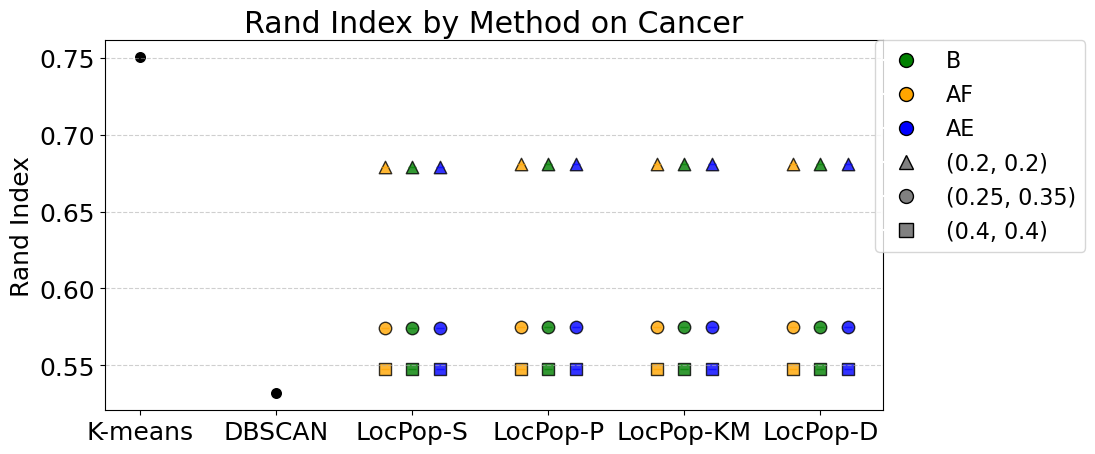

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Cancer-Silhouette Score.png


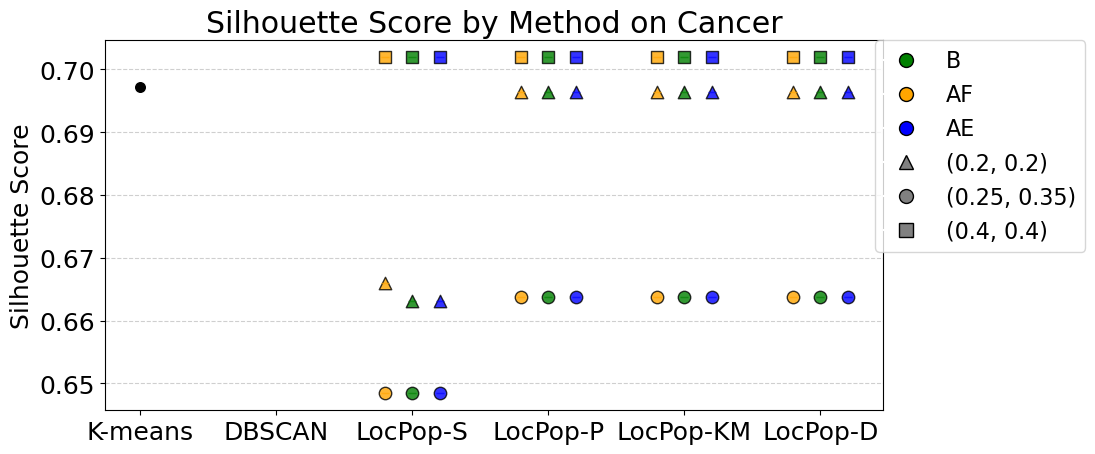

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Iris-Rand Index.png


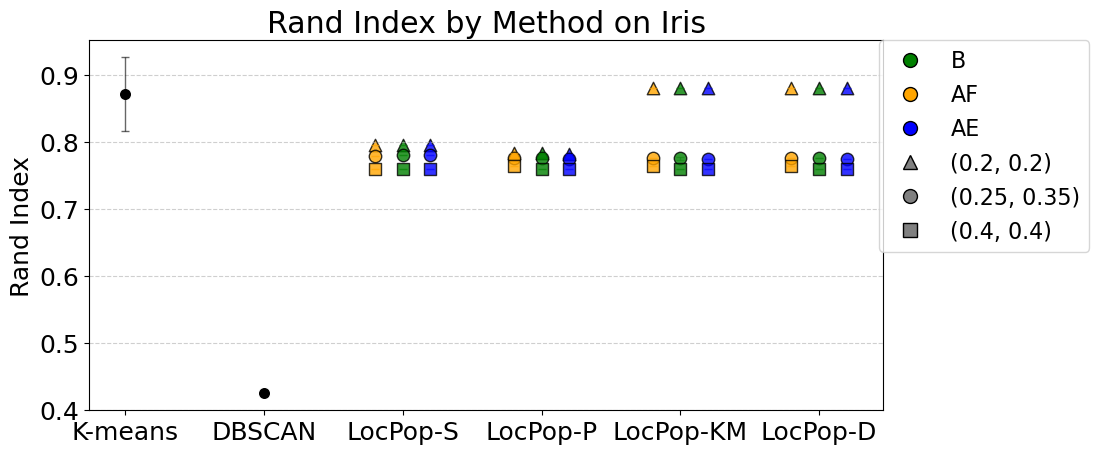

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Iris-Silhouette Score.png


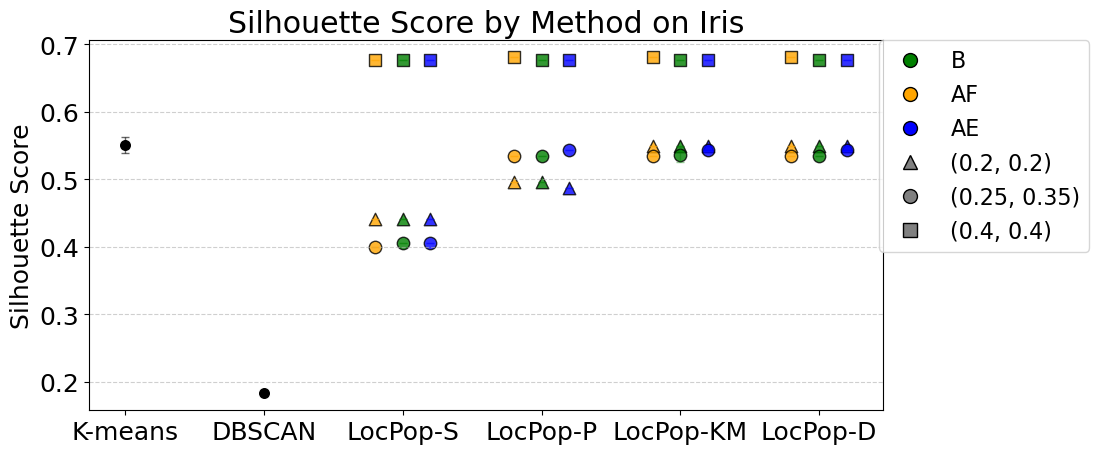

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Moons-Rand Index.png


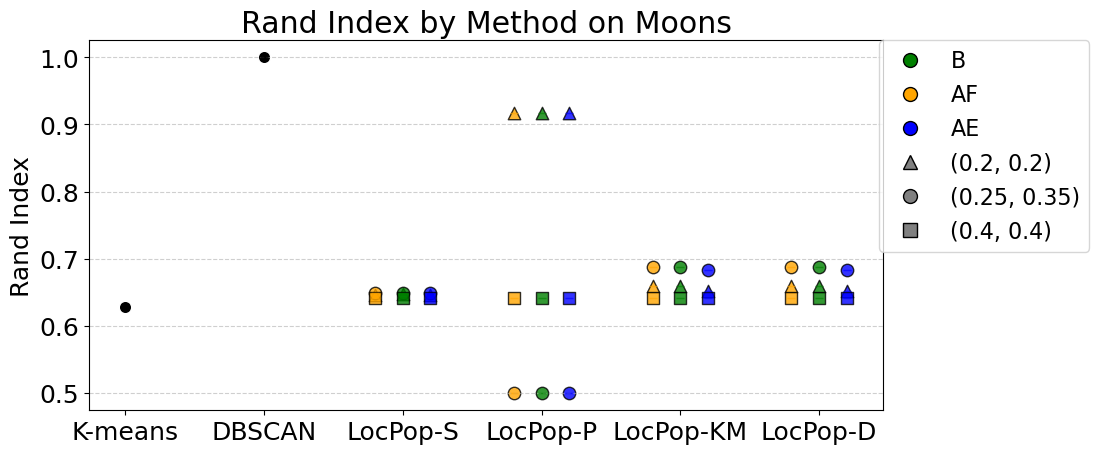

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/Moons-Silhouette Score.png


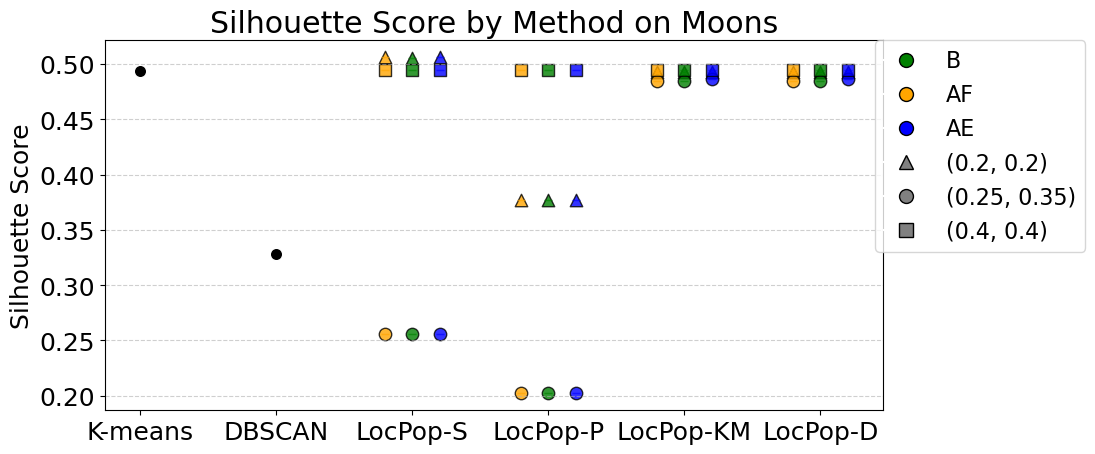

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/3 Circles-Rand Index.png


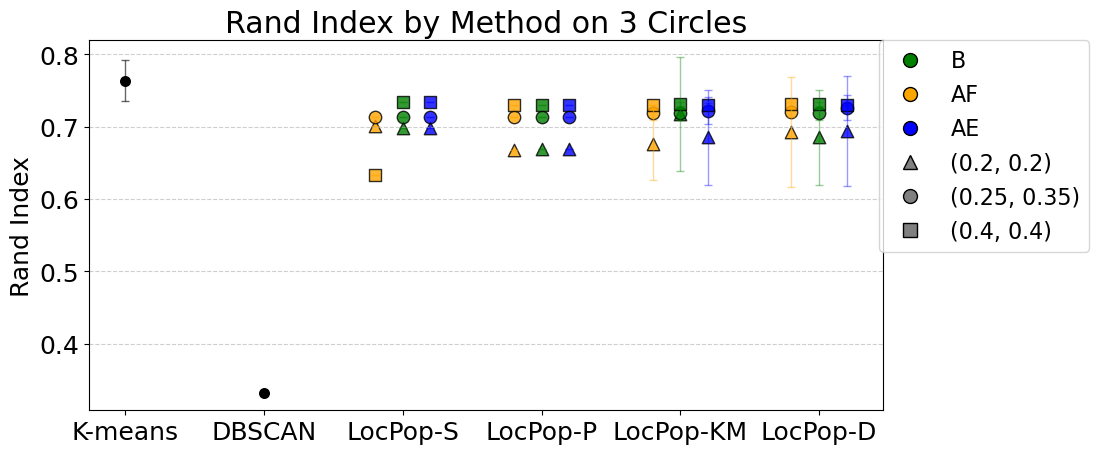

Figure saved as /Users/User/Downloads/local-popular-main-final/noylim/cluster/3 Circles-Silhouette Score.png


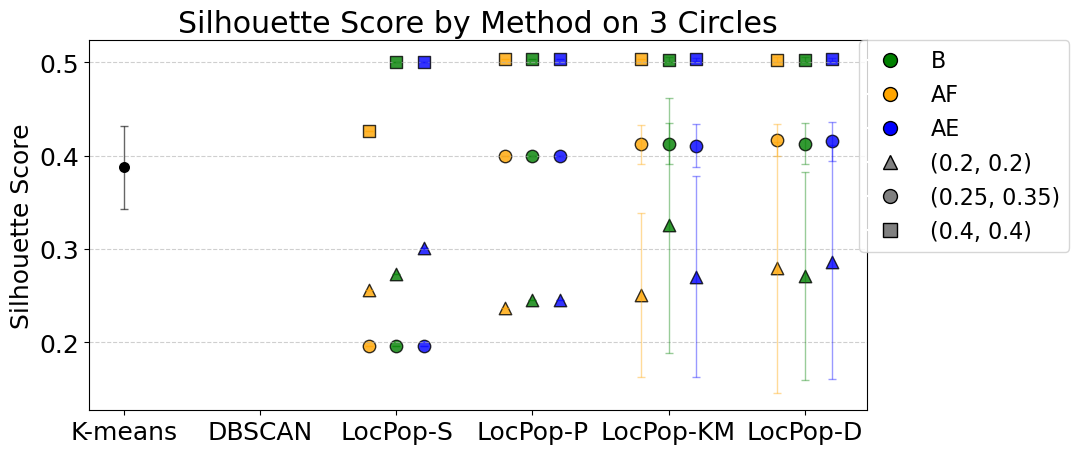

In [9]:
# Save and cleanup data
for i,df in enumerate(dfs):
    df.replace("n.A.", np.nan, inplace=True)
    df.to_csv(f'/Users/User/Downloads/local-popular-main-final/cluster/dataset-{i}.csv', index= False)
score_cols = ['Rand Index', 'Silhouette Score']
dfs = [normalize_score_column(df, score_cols) for df in dfs]
labels = [(0.2,0.2),(0.25,0.35),(0.4,.4)]
# Create figures
for Dataset in ['Cancer', 'Iris', 'Moons', '3 Circles']:
    for score in score_cols:
        plot_and_save(
            dfs, labels, Dataset, score,
            save_path=f'/Users/User/Downloads/local-popular-main-final/noylim/cluster/{Dataset}-{score}.png'
        )

In [10]:
dfs[0]

,Method,Dataset,Rand Index,Silhouette Score,Davies Bouldin Score,Time,Rand Score with initial clustering,Threshold
0,kmeans,Moons,"(0.629159420289855, 0.0016712237709958645)","(0.4938619308764999, 0.00028396463788217145)","(0.7740392952168209, 0.0002922644618504523)","(0.04117741999507416, 0.10864421514104747)",NaN,"(0.2, 0.2)"
1,dbscan,Moons,"(1.0, 0.0)","(0.32774165391434346, 5.551115123125783e-17)","(1.165398401708209, 2.220446049250313e-16)","(0.004292120001628064, 0.0015633530656969385)",NaN,"(0.2, 0.2)"
2,LP (Balanced) Heuristic starting with everyone...,Moons,"(0.6469788182831662, 1.1102230246251565e-16)","(0.5058746421719695, 1.1102230246251565e-16)","(0.6135179911711887, 0.0)","(8.859380700002657, 0.6161461346053687)",NaN,"(0.2, 0.2)"
3,LP (Balanced) Heuristic starting with predicte...,Moons,"(0.9168115942028987, 1.1102230246251565e-16)","(0.3767703745557141, 5.551115123125783e-17)","(1.0208436659864184, 2.220446049250313e-16)","(0.6203573699953268, 0.06740942126109324)",NaN,"(0.2, 0.2)"
4,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6594202898550724, 1.1102230246251565e-16)","(0.49251296994700666, 5.551115123125783e-17)","(0.7782467204602541, 1.1102230246251565e-16)","(0.5797695599962026, 0.04150681550925866)","(0.6594202898550724, 1.1102230246251565e-16)","(0.2, 0.2)"
5,LP (Balanced) Heuristic starting with the outp...,Moons,"(0.6594202898550724, 1.1102230246251565e-16)","(0.49251296994700666, 5.551115123125783e-17)","(0.7782467204602541, 1.1102230246251565e-16)","(0.5675979399937205, 0.04000837091974573)",NaN,"(0.2, 0.2)"
6,LP (Friend-Oriented) Heuristic starting with e...,Moons,"(0.6464437012263098, 1.1102230246251565e-16)","(0.5061438500647323, 1.1102230246251565e-16)","(0.6046857536800483, 1.1102230246251565e-16)","(9.02642341000028, 0.6218262566763068)",NaN,"(0.2, 0.2)"
7,LP (Friend-Oriented) Heuristic starting with p...,Moons,"(0.9168115942028987, 1.1102230246251565e-16)","(0.3767703745557141, 5.551115123125783e-17)","(1.0208436659864184, 2.220446049250313e-16)","(0.6399015200033318, 0.08030884922521228)",NaN,"(0.2, 0.2)"
8,LP (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6594202898550724, 1.1102230246251565e-16)","(0.49251296994700666, 5.551115123125783e-17)","(0.7782467204602541, 1.1102230246251565e-16)","(0.605005900003016, 0.11051163192275121)","(0.6594202898550724, 1.1102230246251565e-16)","(0.2, 0.2)"
9,LP (Friend-Oriented) Heuristic starting with t...,Moons,"(0.6594202898550724, 1.1102230246251565e-16)","(0.49251296994700666, 5.551115123125783e-17)","(0.7782467204602541, 1.1102230246251565e-16)","(0.6194085499912034, 0.1149550542104361)",NaN,"(0.2, 0.2)"
